In [1]:
# 02/19/24 - This notebook redoes some of the kinematic analysis I did for paper 1. See 021924_slacs_kinematics_analysis.ipynb

In [115]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle
from scipy import stats
#import uncertainties.unumpy as unp
#import uncertainties as unc

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
#register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2024_02_15'
date_of_mge = '2023-02-28_2' # The MGEs I did for these kinematics will still be good. don't need to redo them

###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
table_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([15])#10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2024_02_15/



# Paper Table

In [3]:
paper_table = pd.read_csv(f'{table_dir}paper_table_102023.csv')

ellipticities = paper_table.ellipticity
classes = paper_table.class_for_JAM_models

# Bring in the atlas 3d data

In [4]:
## asb is the label, unsure of meaning
atlas3d = np.genfromtxt(f'{data_dir}atlas3d/Emsellem2011_Atlas3D_Paper3_TableB1.txt', skip_header=True)#, names=True)
a3d_eps_vs_lr = atlas3d[:,[2,5,7]]

# Make markers for plotting

In [5]:
# make elliptical marker
import matplotlib.path as mpath

# Define the ellipse marker.
circle = mpath.Path.unit_circle()
elliptical_verts = np.copy(circle.vertices)
elliptical_verts[:, 0] *= 1.618
elliptical_marker = mpath.Path(elliptical_verts, circle.codes)

# define negative smaller ellipse
inner_ell_verts = elliptical_verts * 0.8

# make ellipse with line marker
rect = mpath.Path.unit_rectangle()
rect_verts = np.copy(rect.vertices)
rect_verts[:,0] *= 0.1
rect_verts[:,1] *= 2.0
line_marker = mpath.Path(rect_verts, rect.codes)

# make another line marker lower
second_line_verts = rect_verts.copy()
second_line_verts[:,1] += -3.5
second_line_verts[:,1] *= 0.5

rotator = mpath.Path(
    vertices=np.concatenate([elliptical_verts, inner_ell_verts[::-1, ...], rect_verts, second_line_verts]),
    codes=np.concatenate([circle.codes, circle.codes, rect.codes, rect.codes]))

nonregular = 'o'

# make a question mark
uncertain_mark = '$?$'

# fast/non (kdc)
kdc_mark = '^'


# The V/sigma and Lambda_R plots require some lines that are calculated theoretically

In [6]:

def calc_V_sigma_squared (delta, omega, alpha, i):
    
    if delta >= 1 - 1/omega: # upper limit by tensor virial theorem
        V_sigma_sq = 'NaN'
        return V_sigma_sq
    
    else:
        # radians
        i = i * np.pi/180

        numerator = (1-delta) * omega - 1
        denominator = alpha * (1-delta) * omega + 1

        V_sigma_sq = numerator/denominator

        # project by i
        V_sigma_sq = V_sigma_sq * (np.sin(i))**2 / (1 - delta * (np.cos(i))**2)

        return V_sigma_sq

def calc_omega (e):
    
    numerator = np.arcsin(e)/np.sqrt(1-e**2) - e
    denominator = e - np.arcsin(e) * np.sqrt(1-e**2)
    
    omega = 0.5 * numerator/denominator
    
    return omega

def calc_e (epsilon_intr):
    
    e = np.sqrt( 1 - (1 - epsilon_intr)**2 )
    
    return e

def calc_eps_intr (epsilon, i):
    
    # radians
    i = i * np.pi/180
    
    epsilon_intr = 1 - np.sqrt(1 + epsilon * (epsilon - 2)/(np.sin(i))**2)
    
    return epsilon_intr

def calc_i_from_eps_intr (epsilon, epsilon_intr):
    
    i = np.arcsin( np.sqrt( epsilon/epsilon_intr * (epsilon - 2) / (epsilon_intr - 2)) )
    
    # put in degrees
    i = i * 180 / np.pi
    
    return(i)

def calc_isotropic_V_sigma (epsilon, i):
    
    # isotropic delta = 0
    delta = 0
    # alpha empirically = 0.15
    alpha = 0.15
    
    # calculations
    epsilon_intr = calc_eps_intr(epsilon, i)
    e = calc_e(epsilon_intr)
    omega = calc_omega(e)
    V_sigma_squared = calc_V_sigma_squared(delta, omega, alpha, i)
    V_sigma_iso = np.sqrt(V_sigma_squared)
    
    return(V_sigma_iso)

def calc_V_sigma_magenta_line (epsilon, i, epsilon_intr=None):
    
    # alpha empirically = 0.15
    alpha = 0.15
    
    # calculations
    if epsilon_intr is None:
        epsilon_intr = calc_eps_intr(epsilon, i)
    else:
        i = calc_i_from_eps_intr(epsilon, epsilon_intr)
    e = calc_e(epsilon_intr)
    omega = calc_omega(e)
    # isotropic delta = 0
    delta = 0.7 * epsilon_intr
    
    V_sigma_squared = calc_V_sigma_squared(delta, omega, alpha, i)
    V_sigma_magenta = np.sqrt(V_sigma_squared)
    
    return(V_sigma_magenta)


def calc_lambda_R (V_array, VD_array, R_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(R_array))
    
    numerator = 0
    denominator = 0
    
    for i in range(len(V_array)):
        V = V_array[i]
        VD = VD_array[i]
        lum = lum_array[i]
        R = R_array[i]
        
        num = lum * R * np.abs(V)
        den = lum * R * np.sqrt(V**2 + VD**2)
        
        numerator += num
        denominator += den
        
    lambda_R = numerator / denominator
    
    return lambda_R

def calc_Vsig_to_lamR (V_sigma):
    k = 1.1
    numerator = k * V_sigma
    denominator = np.sqrt(1 + k**2 * V_sigma**2)
    lamR = numerator/denominator
    return lamR

def calc_R (bin_arrays, num_bins):
    
    bin_R_means = np.zeros(num_bins)
    
    for i in range(num_bins):
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)
        bin_R_means[i] = np.mean(bin_R)*0.1457
        
    return bin_R_means

In [7]:
# inclinations
incs = np.array([15, 30, 45, 60, 75, 90])
eps_intrs = np.arange(0.1,0.9,0.1)

plt.rcParams.update({'font.size': 14})

epsilons = np.linspace(0.0,1.0,1000)
V_sigmas_iso = np.zeros(1000)
lambda_Rs_iso = np.zeros(1000)
V_sigmas_magenta = np.zeros((len(incs), 1000)) # Do the magenta over 6 inclinations
lambda_Rs_magenta = np.zeros((len(incs), 1000)) # Do the magenta over 6 inclinations
V_sigmas_mag_intrs = np.zeros((len(eps_intrs), 1000))
lambda_Rs_mag_intrs = np.zeros((len(eps_intrs), 1000))

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon, 90)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1
    
for i, epsilon in enumerate(epsilons):
    for j, inc in enumerate(incs):
        V_sigma = calc_V_sigma_magenta_line(epsilon, inc)
        V_sigmas_magenta[j,i] = V_sigma
        lambda_Rs_magenta[j,i] = calc_Vsig_to_lamR(V_sigma)
    for k, eps_intr in enumerate(eps_intrs):
        V_sigma = calc_V_sigma_magenta_line(epsilon, 90, epsilon_intr=eps_intr)
        V_sigmas_mag_intrs[k,i] = V_sigma
        lambda_Rs_mag_intrs[k,i] = calc_Vsig_to_lamR(V_sigma)

/tmp/ipykernel_132206/2476325670.py:26: RuntimeWarning: invalid value encountered in scalar divide
  omega = 0.5 * numerator/denominator
/tmp/ipykernel_132206/2476325670.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  numerator = np.arcsin(e)/np.sqrt(1-e**2) - e
/tmp/ipykernel_132206/2476325670.py:14: RuntimeWarning: invalid value encountered in scalar divide
  V_sigma_sq = numerator/denominator
/tmp/ipykernel_132206/2476325670.py:41: RuntimeWarning: invalid value encountered in sqrt
  epsilon_intr = 1 - np.sqrt(1 + epsilon * (epsilon - 2)/(np.sin(i))**2)
/tmp/ipykernel_132206/2476325670.py:47: RuntimeWarning: invalid value encountered in arcsin
  i = np.arcsin( np.sqrt( epsilon/epsilon_intr * (epsilon - 2) / (epsilon_intr - 2)) )


In [8]:
for i in range(len(V_sigmas_magenta)):
    V_sigmas_magenta[i][V_sigmas_magenta[i]>V_sigmas_mag_intrs[-1]] = 'Nan'

# Functions to calculate the luminosity-weighted aperture velocities

In [9]:
# Define function to calculate luminosity weights for rebinning from Voronoi bins to shells
### In this case, the shell will justbe the effective radius (shells = [1])

def calc_luminosity_weights_in_shells (bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells, reff):
    
    # create array with each bin and len num_bins
    luminosity_weights = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # luminosity of bin and of pixels in bin
        #bin_luminosity = bin_luminosities[i]
        bin_pixels_lum = pixel_luminosities[in_bin]
        #print(bin_luminosity, np.sum(bin_pixels_lum))
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            # weight pixels by fractional luminosity of total bin
            bin_luminosity_in_shell = np.sum(bin_pixels_lum[in_shell])#/bin_luminosity
            luminosity_weights[i,k] = bin_luminosity_in_shell
        
    return luminosity_weights

def lum_weight_bin (V, VD, dV, dVD, lum):
    
    bin_weighted_V_sq = lum * V**2
    bin_weighted_VD_sq = lum * VD**2
    bin_weighted_dV_sq = lum * 2 * V * dV
    bin_weighted_dVD_sq = lum * 2 * VD * dVD

    return bin_weighted_V_sq, bin_weighted_VD_sq, bin_weighted_dV_sq, bin_weighted_dVD_sq

def lum_weight_V_sigma (V_array, VD_array, dV_array, dVD_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(dVD_array))
    
    V_sq = 0
    VD_sq = 0
    dV_sq = 0
    dVD_sq = 0
    
    for i in range(len(V_array)):
        bin_V_sq, bin_VD_sq, bin_dV_sq, bin_dVD_sq = lum_weight_bin(V_array[i], VD_array[i], dV_array[i], dVD_array[i], lum_array[i])
        V_sq += bin_V_sq
        VD_sq += bin_VD_sq
        dV_sq += bin_dV_sq
        dVD_sq += bin_dVD_sq
    
    V_sigma_sq = V_sq/VD_sq
    V_sigma = np.sqrt(V_sigma_sq)
    
    V_integrated_rms = np.sqrt(V_sq/np.sum(lum_array))
    VD_integrated_rms = np.sqrt(VD_sq/np.sum(lum_array))
    
    dV_int_rms = dV_sq / (2 * np.sqrt(np.sum(lum_array) * V_sq))
    dVD_int_rms = dVD_sq / (2 * np.sqrt(np.sum(lum_array) * VD_sq))
    
    return(V_sigma, V_integrated_rms, VD_integrated_rms, dV_int_rms, dVD_int_rms) # this is integrated out to the edge of my data right now
        
    
# Define function to assign velocities to each pixel from their Voronoi bin, taking only those within the effective radius

def calc_aperture_velocities_from_lum_weight_pixels (bin_arrays, V_array, VD_array, dV_array, dVD_array, pixel_luminosities, reff):
    
    # create array for velocity of each pixel
    pixel_Vs = np.zeros(len(pixel_luminosities))
    pixel_VDs = np.zeros(len(pixel_luminosities))
    pixel_dVs = np.zeros(len(pixel_luminosities))
    pixel_dVDs = np.zeros(len(pixel_luminosities))
    velocity_in_aperture = 0
    
    for i in range(num_bins):
        # pixels in this bin
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        # add velocity to the weighted_pixel_velocities
        pixel_Vs[in_bin] = V_array[i]
        pixel_VDs[in_bin] = VD_array[i]
        pixel_dVs[in_bin] = dV_array[i]  
        pixel_dVDs[in_bin] = dVD_array[i]       
        
    # get radius of pixels
    pixel_xx = bin_arrays[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
    pixel_yy = bin_arrays[:,1] - 21
    # calculate radius of each pixel
    pixel_radii = np.sqrt(pixel_xx**2 + pixel_yy**2)*0.1457 # arcsec
    # if they are in the effective radius
    in_aperture = (pixel_radii <= reff)
    
    # take values only in the aperture for weighting
    pixel_Vs_aperture = pixel_Vs[in_aperture]
    pixel_VDs_aperture = pixel_VDs[in_aperture]
    pixel_dVs_aperture = pixel_dVs[in_aperture]
    pixel_dVDs_aperture = pixel_dVDs[in_aperture]
    pixel_radii_aperture = pixel_radii[in_aperture]
    pixel_luminosities_aperture = pixel_luminosities[in_aperture]
    
    # mask all NaN values
    V_mask = np.isfinite(pixel_Vs_aperture)
    VD_mask = np.isfinite(pixel_VDs_aperture)
    dV_mask = np.isfinite(pixel_dVs_aperture)
    dVD_mask = np.isfinite(pixel_dVDs_aperture)
    rad_mask = np.isfinite(pixel_radii_aperture)
    lum_mask = np.isfinite(pixel_luminosities_aperture)
    mask = (V_mask) & (VD_mask) & (dV_mask) & (dVD_mask) & (rad_mask) & (lum_mask)
    
    if any(mask):
        print('Masking NaN pixels.')
    
    # normalize pixel luminosities
    normalized_pixel_luminosities_aperture = pixel_luminosities_aperture[mask]/np.sum(pixel_luminosities_aperture[mask])
    
    # weight squared pixel velocities by pixel luminosity
    lum_weighted_pixel_Vs_sq = pixel_Vs_aperture[mask]**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_VDs_sq = pixel_VDs_aperture[mask]**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVs_sq = 2 * pixel_Vs_aperture[mask] * pixel_dVs_aperture[mask] * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVDs_sq = 2 * pixel_VDs_aperture[mask] * pixel_dVDs_aperture[mask] * normalized_pixel_luminosities_aperture
    
    # take the square root of the sum of the weighted square velocities in the aperture                                                
    lum_weighted_aperture_V = np.sqrt(np.sum(lum_weighted_pixel_Vs_sq)) # this is right
    lum_weighted_aperture_VD = np.sqrt(np.sum(lum_weighted_pixel_VDs_sq))
    lum_weighted_aperture_dV = np.sum(lum_weighted_pixel_dVs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_Vs_sq))) # this is right
    lum_weighted_aperture_dVD = np.sum(lum_weighted_pixel_dVDs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_VDs_sq)))
    ###### 02/16/23 - I double-checked this again, and I *believe* it is correct. I do not think I need to do any additional dividing of
    ######            # I've added the squared values in quadrature, and all of it should be correct.
    
    # calculate V/sigma
    V_sigma = lum_weighted_aperture_V/lum_weighted_aperture_VD
    
    # calculate lambda_R
    numerator = np.sum(pixel_radii_aperture[mask] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq))
    denominator = np.sum(pixel_radii_aperture[mask] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq +  lum_weighted_pixel_VDs_sq))
    lambda_R = numerator / denominator
    print('lambda_R, ', lambda_R)
    if ~np.isfinite(lambda_R):
        print(normalized_pixel_luminosities_aperture[normalized_pixel_luminosities_aperture < 0])

    
    return V_sigma, lambda_R, lum_weighted_aperture_V, lum_weighted_aperture_VD, lum_weighted_aperture_dV, lum_weighted_aperture_dVD

# Function for getting the proper range to sum over wavelengths.

In [10]:
# define function to cut to the right wavelength range for summing over flux.

def cut_wavelength_range (obj_abbr, mos_dir, z):
    
    # take the widest wavelength range I used for fitting the spectra
    wavelo = 3400#3150
    if obj_abbr == 'J0330':
        wavehi = 4150
    else:
        wavehi = 4300#4350
    
    # redshift those boudnaries
    wavelo_redshift = wavelo * (1 + z)
    wavehi_redshift = wavehi * (1 + z)
    
    # take the mosaic header to find the lower and upper wavelength bounds
    #mosaic_data = fits.getdata(f'{mos_dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits')
    mosaic_header = fits.getheader(f'{mos_dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits')
    wavespeclo = mosaic_header['CRVAL3']
    wavespechi = wavespeclo + 5215/2

    low_ind = (wavelo_redshift - wavespeclo)*2
    hi_ind = (wavehi_redshift - wavespeclo)*2
    
    low_ind = int(np.rint(low_ind))
    hi_ind = int(np.rint(hi_ind))
    
    return(low_ind, hi_ind)

In [11]:
# Only do SN 15
vorbin_SN_target = 15
sps_name = 'xshooter'

# Now we calculate the actual integrated velocities.

In [12]:
V_sigmas = np.zeros( (len(obj_names)) )
lambda_Rs = np.zeros( (len(obj_names)) )
V_ap_int_rms = np.zeros( (len(obj_names)) )
VD_ap_int_rms = np.zeros( (len(obj_names)) )
dV_ap_int_rms = np.zeros( (len(obj_names)) )
dVD_ap_int_rms = np.zeros( (len(obj_names)) )


In [13]:


#for i, obj_name in enumerate(obj_names):
for i in range(14):
    
    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    
    kin_dir = f'{kinematics_dir}{obj_name}/'
    
    # get the kinematics from the january date
    with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        kin_data = pickle.load(file)
        
    # get details from jampy for the velocity corrected by barycenter velocity
    with open(f'{kin_dir}{obj_name}_details_for_jampy_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        jam_data = pickle.load(file)

    #KCWI mosaic datacube
    mos_dir = f'{mosaics_dir}{obj_name}/'
    mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    '''
    Step 0: input the necessary information of the datacube
    '''
    
    #################
    # get velocity and bin data 

    # bin velocity dispersion
    _, VD_bin, _, dVD_bin, chi2_bin = kin_data.bin_kinematics.T
        
    # bin mean velocity
    V_bin = jam_data.V_bin
    dV_bin = jam_data.dV_bin
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = kin_data.voronoi_binning_data 
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = kin_data.voronoi_binning_output
    
    # mask the bins greater than 350
    mask_bins = VD_bin > 350
    if any(mask_bins):
        VD_bin[mask_bins] = np.nan
        dVD_bin[mask_bins] = np.nan
        V_bin = np.insert(V_bin, np.argwhere(mask_bins)[0], np.nan)
        dV_bin = np.insert(dV_bin, np.argwhere(mask_bins)[0], np.nan)

    #################
    # get the right wavelength range from observations
    z = paper_table.loc[i, 'zlens']
    lo_ind, hi_ind = cut_wavelength_range (obj_abbr, mos_dir, z)
    print('Wavelength bounds for summation: ', lo_ind, hi_ind)        

    ######################################################################################
    ###########################################
    '''
    Now pixel method
    '''
    ###########################################
    ######################################################################################
    print()
    print('Starting pixel method...')
    print()
    print('################################################')

    # bring in cropped datacube and sum across wavelengths
    file = f'{mos_dir}{mos_name}_crop.fits'
    datacube = fits.getdata(file)
    summed_datacube = np.nansum(datacube[lo_ind:hi_ind], axis=0) # cut to the correct wavelength range
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    effective_radius = paper_table.loc[i, 'reff_slacs']

    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        if pixel_luminosity < 0:
            print('negative pixel luminosity! ', pixel_luminosity)
            print('mean pixel luminosity, ', np.mean(pixel_luminosities))
            print('making this pixel 0 luminosity...')
            pixel_luminosity = 0
        pixel_luminosities[j] = pixel_luminosity

    # calculate V_sigma# calculate lambda_R
    V_sigmas[i], lambda_Rs[i], \
        V_ap_int_rms[i], VD_ap_int_rms[i], \
        dV_ap_int_rms[i], dVD_ap_int_rms[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                         V_bin, VD_bin, dV_bin, dVD_bin, 
                                                                                                                         pixel_luminosities, 
                                                                                                                         effective_radius)





################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

In [14]:
# Now look at the values

In [15]:
V_sigmas

array([0.08009841, 0.16225818, 0.10943564, 0.22005324, 0.07033591,
       0.12539358, 0.10047509, 0.08415212, 0.08474035, 0.05016137,
       0.22940663, 0.08648585, 0.11176216, 0.06690848])

In [16]:
lambda_Rs

array([0.06259693, 0.14855528, 0.09212595, 0.19529851, 0.05891375,
       0.10901089, 0.08520041, 0.0705594 , 0.0735756 , 0.04483537,
       0.21052038, 0.07630245, 0.09573152, 0.05891509])

# Plot

In [17]:
classes

0     slow
1     slow
2     slow
3     fast
4     slow
5     fast
6     slow
7     slow
8     slow
9     slow
10    fast
11    slow
12    slow
13    slow
Name: class_for_JAM_models, dtype: object

In [18]:
slow = classes == 'slow'#/nonregular'
fast = classes == 'fast'#/regular'
uncertain = classes == 'uncertain' # J0330
kdc = classes == 'fast/nonregular' #J1538

# separate into fast and slow
eps_slow = ellipticities[slow]
eps_fast = ellipticities[fast]

#################################################
#### pixel method
V_sigmas_pix_slow = V_sigmas[slow]
V_sigmas_pix_fast = V_sigmas[fast]

lambda_Rs_pix_slow = lambda_Rs[slow]
lambda_Rs_pix_fast = lambda_Rs[fast]

# uncertain
eps_uncertain = ellipticities[uncertain]
V_sigmas_pix_uncertain = V_sigmas[uncertain]
lambda_Rs_pix_uncertain = lambda_Rs[uncertain]

# fast nonregular
eps_fast_kdc = ellipticities[kdc]
V_sigmas_pix_fast_kdc = V_sigmas[kdc]
lambda_Rs_pix_fast_kdc = lambda_Rs[kdc]

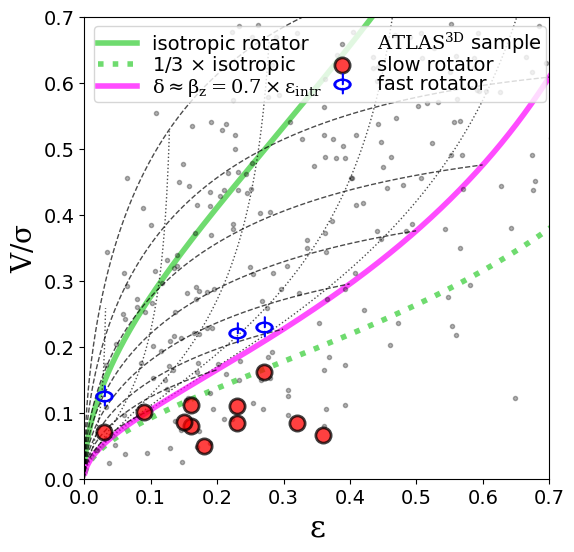

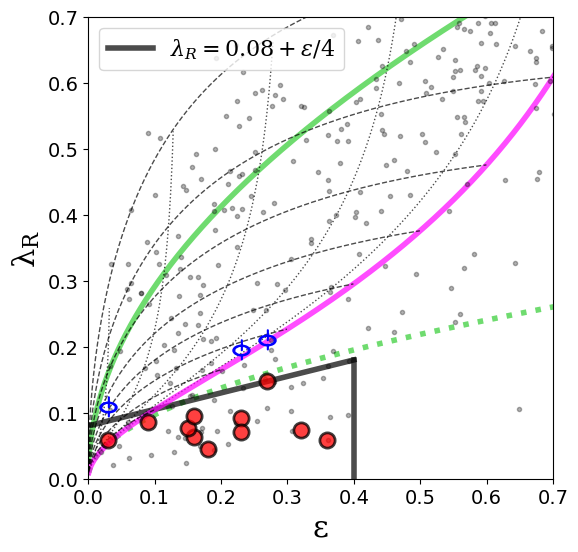

In [147]:
# plot the V_sigma and lambda_R to ellipticities


plt.figure(figsize=(6,6))
plt.xlim(0.0,0.7)#1.0)
plt.ylim(0.0,0.7)#1.0)

# curves
plt.plot(epsilons, V_sigmas_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
        label='isotropic rotator')
plt.plot(epsilons, 1/3 * V_sigmas_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7, linestyle=':',
        label=r'1/3 $\times$ isotropic')
# plot magenta and different inclinations
for i in range(len(incs)):
    if i == len(incs)-1:
        c='magenta'
        linestyle='-'
        label=r'$\mathrm{\delta\approx\beta_z=0.7\times\epsilon_{intr}}$'
        linewidth=4
    else:
        c = 'k'
        linestyle=':'
        label=None
        linewidth=1
    plt.plot(epsilons, V_sigmas_magenta[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)
# plot different epsilon intrinsic for magenta line
# plot magenta and different eps_intr
for i in range(len(eps_intrs)):
    c = 'k'
    linestyle='--'
    label=None
    linewidth=1
    plt.plot(epsilons, V_sigmas_mag_intrs[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)
    
########
# atlas3d points
plt.scatter(a3d_eps_vs_lr[:,0], a3d_eps_vs_lr[:,1], c='k', marker='.', alpha=0.3, zorder=-1, label=r'$\rm{ATLAS^{3D}}$ sample')

# scatter plot for the datapoints
plt.scatter(eps_slow, V_sigmas_pix_slow[:], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=2,
            label='slow rotator', alpha=0.75)
plt.scatter(eps_fast, V_sigmas_pix_fast[:], 
            s=230, c='b', marker=rotator, 
            label='fast rotator')#detectable rotation')
#plt.scatter(eps_uncertain, V_sigmas_pix_uncertain[:], 
#            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
#            label='uncertain')
#plt.scatter(eps_fast_kdc, V_sigmas_pix_fast_kdc[:], 
#            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
#            label='KDC')

plt.xlabel(r'$\mathrm{\epsilon}$',fontsize=22)
plt.ylabel(r'$\mathrm{V/\sigma}$',fontsize=20)
plt.legend(fontsize=14, loc='upper left', ncol=2, columnspacing=0, labelspacing=0, borderpad=0.2)
#if j != 3:
#    plt.title(f'S/N {vorbin_SN_targets[j]}')
plt.savefig(f'{kinematics_dir}/kinematic_classes_vsigma.png')
plt.savefig(f'{kinematics_dir}/kinematic_classes_vsigma.pdf')

###################################
# Lambda_R

plt.figure(figsize=(6,6))
plt.xlim(0.0,0.7)#1.0)
plt.ylim(0.0,0.7)#1.0)

# curves
plt.plot(epsilons, lambda_Rs_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
plt.plot(epsilons, 1/3 * lambda_Rs_iso, 
         c='limegreen', linestyle=':', linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.0, 0.4],[0.08, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.4, 0.4],[0.0, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')
#plt.plot(epsilons, 0.31 * np.sqrt(epsilons), c='r')

# plot magenta and different inclinations
for i in range(len(incs)):
    if i == len(incs)-1:
        c='magenta'
        linestyle='-'
        #label=r'$\delta=0.7\times\epsilon_{intr}$'
        linewidth=4
    else:
        c = 'k'
        linestyle=':'
        label=None
        linewidth=1
    plt.plot(epsilons, V_sigmas_magenta[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)
# plot different epsilon intrinsic for magenta line
# plot magenta and different eps_intr
for i in range(len(eps_intrs)):
    c = 'k'
    linestyle='--'
    label=None
    linewidth=1
    plt.plot(epsilons, V_sigmas_mag_intrs[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)

# scatter plots for the datapoints
plt.scatter(eps_slow, lambda_Rs_pix_slow[:], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=2,
            #label='no rotation', 
            alpha=0.75)
plt.scatter(eps_fast, lambda_Rs_pix_fast[:], 
            s=230, c='b', marker=rotator, 
            #label='detectable rotation'
           )
#plt.scatter(eps_uncertain, lambda_Rs_pix_uncertain[:], 
#            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            #label='uncertain'
#           )
plt.scatter(eps_fast_kdc, lambda_Rs_pix_fast_kdc[:], 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            #label='KDC'
           )

########
# atlas3d points
plt.scatter(a3d_eps_vs_lr[:,0], a3d_eps_vs_lr[:,2], c='k', marker='.', alpha=0.3, zorder=-1)

plt.xlabel(r'$\mathrm{\epsilon}$',fontsize=22)
plt.ylabel(r'$\mathrm{\lambda_R}$',fontsize=22)
plt.legend(fontsize=16, loc='upper left')
#if j != 3:
#    plt.title(f'S/N {vorbin_SN_targets}')
plt.savefig(f'{kinematics_dir}/kinematic_classes_lambdar.png')
plt.savefig(f'{kinematics_dir}/kinematic_classes_lambdar.pdf')

# Look at aperture effects by integrating velocities at a range of aperture radii.
# 1/4 reff, 1/2 reff, 3/4 reff, 1 reff, 1.25, 1.5 etc


In [20]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

reff_factors = np.arange(0.1, 1.6, 0.1)

V_sigmas_aptest = np.zeros( (len(obj_names), len(reff_factors)) )
lambda_Rs_aptest = np.zeros_like( V_sigmas_aptest )
V_ap_int_aptest = np.zeros_like( V_sigmas_aptest )
VD_ap_int_aptest = np.zeros_like( V_sigmas_aptest )
dV_ap_int_aptest = np.zeros_like( V_sigmas_aptest )
dVD_ap_int_aptest = np.zeros_like( V_sigmas_aptest )


for i, obj_name in enumerate(obj_names):
    
    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    
    kin_dir = f'{kinematics_dir}{obj_name}/'
    
    # get the kinematics from the january date
    with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        kin_data = pickle.load(file)
        
    # get details from jampy for the velocity corrected by barycenter velocity
    with open(f'{kin_dir}{obj_name}_details_for_jampy_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        jam_data = pickle.load(file)

    #KCWI mosaic datacube
    mos_dir = f'{mosaics_dir}{obj_name}/'
    mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    '''
    Step 0: input the necessary information of the datacube
    '''
    
    #################
    # get velocity and bin data 

    # bin velocity dispersion
    _, VD_bin, _, dVD_bin, chi2_bin = kin_data.bin_kinematics.T
        
    # bin mean velocity
    V_bin = jam_data.V_bin
    dV_bin = jam_data.dV_bin
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = kin_data.voronoi_binning_data 
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = kin_data.voronoi_binning_output
    
    # mask the bins greater than 350
    mask_bins = VD_bin > 350
    if any(mask_bins):
        VD_bin[mask_bins] = np.nan
        dVD_bin[mask_bins] = np.nan
        V_bin = np.insert(V_bin, np.argwhere(mask_bins)[0], np.nan)
        dV_bin = np.insert(dV_bin, np.argwhere(mask_bins)[0], np.nan)

    #################
    # get the right wavelength range from observations
    z = paper_table.loc[i, 'zlens']
    lo_ind, hi_ind = cut_wavelength_range (obj_abbr, mos_dir, z)
    print('Wavelength bounds for summation: ', lo_ind, hi_ind)        

    ######################################################################################
    ###########################################
    '''
    Now pixel method
    '''
    ###########################################
    ######################################################################################
    print()
    print('Starting pixel method...')
    print()
    print('################################################')

    # bring in cropped datacube and sum across wavelengths
    file = f'{mos_dir}{mos_name}_crop.fits'
    datacube = fits.getdata(file)
    summed_datacube = np.nansum(datacube[lo_ind:hi_ind], axis=0) # cut to the correct wavelength range
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    effective_radius = paper_table.loc[i, 'reff_slacs']
    
    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        if pixel_luminosity < 0:
            print('negative pixel luminosity! ', pixel_luminosity)
            print('mean pixel luminosity, ', np.mean(pixel_luminosities))
            print('making this pixel 0 luminosity...')
            pixel_luminosity = 0
        pixel_luminosities[j] = pixel_luminosity

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V_bin))
    print(f'length before cutting... {len(R)}')
    for m, factor in enumerate(reff_factors):
        print('factor ', factor)
        aperture_radius = factor*effective_radius
        condition = R < aperture_radius
        R_in_aperture = R[condition]
        V_in_aperture = V_bin[condition]
        VD_in_aperture = VD_bin[condition]
        dV_in_aperture = dV_bin[condition]
        dVD_in_aperture = dVD_bin[condition]
        print(f'length after cutting... {len(R_in_aperture)}')
        #print()

        ######################################################################################
        ###########################################
        '''
        Now pixel method only (no bin method, they give the same result)
        '''
        ###########################################
        ######################################################################################
        print()
        print('Starting pixel method...')
        print()
        print('################################################')


        # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
        #shells=[1.]
        #luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
        #                                                       num_bins, 
        #                                                       bin_luminosities=None, 
        #                                                       pixel_luminosities, 
        #                                                       shells, 
        #                                                       aperture_radius)

        # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
        #sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
        #normalized_lum_weights = luminosity_weights / sum_lum_weights

        # calculate V_sigma# calculate lambda_R
        V_sigmas_aptest[i,m], lambda_Rs_aptest[i,m], \
            V_ap_int_aptest[i,m], VD_ap_int_aptest[i,m], \
            dV_ap_int_aptest[i,m], dVD_ap_int_aptest[i,m]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                             V_bin, VD_bin, dV_bin, dVD_bin, 
                                                                                                                             pixel_luminosities, 
                                                                                                                             aperture_radius)





################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

/tmp/ipykernel_132206/896716072.py:146: RuntimeWarning: invalid value encountered in scalar divide
  lambda_R = numerator / denominator


Wavelength bounds for summation:  1719 3936

Starting pixel method...

################################################
length before cutting... 85
factor  0.1
length after cutting... 5

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.027922458409221335
factor  0.2
length after cutting... 16

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.023982930965174797
factor  0.30000000000000004
length after cutting... 26

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.03819322230425748
factor  0.4
length after cutting... 42

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.05338424357954399
factor  0.5
length after cutting... 46

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.05912028648583509
facto

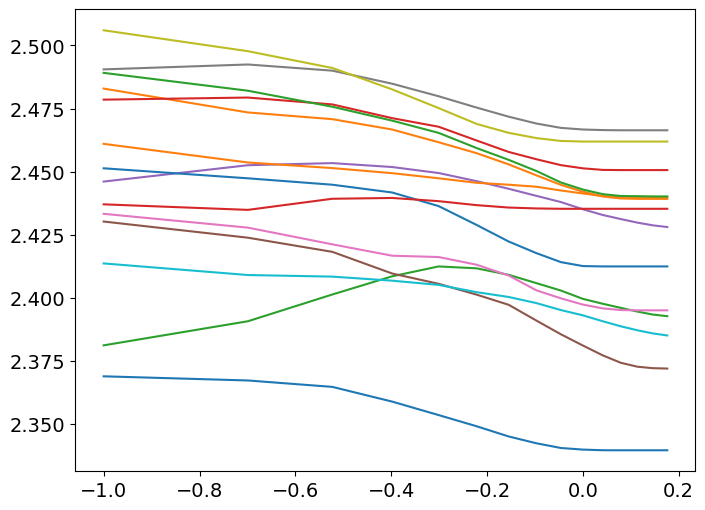

In [21]:
for i in range(len(obj_names)):
    plt.plot(np.log10(reff_factors), np.log10(VD_ap_int_aptest[i]))

In [22]:
# also show the 1/2 Reff measurement
VD_half_reff = VD_ap_int_aptest[:,4]
dVD_half_reff = dVD_ap_int_aptest[:,4]
VD_half_reff

array([225.68243909, 289.49538815, 258.47557951, 293.61958435,
       281.47536153, 254.40667434, 260.69891992, 301.9001231 ,
       298.65960699, 254.15245899, 273.10634167, 280.12468598,
       291.97673373, 274.33790698])

In [23]:
dVD_half_reff

array([ 8.11430629,  7.6432015 , 11.35453014,  6.11435321,  6.62578736,
        6.16749561,  9.49209239,  7.89893599, 12.24349655,  6.30889517,
       11.63024799, 12.60727202,  7.74785653, 10.53159455])

In [24]:
# also show the 1/2 Reff measurement
VD_reff = VD_ap_int_aptest[:,9]
dVD_reff = dVD_ap_int_aptest[:,9]
VD_reff

array([218.68388824, 276.71858407, 250.93308242, 282.6829073 ,
       272.31815826, 240.47292896, 249.62690893, 292.87860256,
       289.67934157, 247.19159157, 258.55848245, 276.27584925,
       277.26333028, 272.4353285 ])

In [25]:
dVD_reff

array([10.0381177 ,  8.89961147, 12.70941126,  7.38575054,  9.23677949,
        7.79861751, 12.0823912 ,  9.23837187, 13.12354281,  8.82427908,
       13.83060824, 17.49294946, 10.92515265, 11.50529183])

# Now integrated within 1.5 arcseconds.

In [26]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

aperture_radius = 1.5

V_sigmas_sdssap = np.zeros( (len(obj_names)) ) #, len(reff_factors)) )
lambda_Rs_sdssap = np.zeros_like( V_sigmas_sdssap )
V_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )
VD_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )
dV_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )
dVD_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )


for i in range(14):
    
    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    
    kin_dir = f'{kinematics_dir}{obj_name}/'
    
    # get the kinematics from the january date
    with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        kin_data = pickle.load(file)
        
    # get details from jampy for the velocity corrected by barycenter velocity
    with open(f'{kin_dir}{obj_name}_details_for_jampy_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        jam_data = pickle.load(file)

    #KCWI mosaic datacube
    mos_dir = f'{mosaics_dir}{obj_name}/'
    mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    '''
    Step 0: input the necessary information of the datacube
    '''
    
    #################
    # get velocity and bin data 

    # bin velocity dispersion
    _, VD_bin, _, dVD_bin, chi2_bin = kin_data.bin_kinematics.T
        
    # bin mean velocity
    V_bin = jam_data.V_bin
    dV_bin = jam_data.dV_bin
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = kin_data.voronoi_binning_data 
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = kin_data.voronoi_binning_output
    
    # mask the bins greater than 350
    mask_bins = VD_bin > 350
    if any(mask_bins):
        VD_bin[mask_bins] = np.nan
        dVD_bin[mask_bins] = np.nan
        V_bin = np.insert(V_bin, np.argwhere(mask_bins)[0], np.nan)
        dV_bin = np.insert(dV_bin, np.argwhere(mask_bins)[0], np.nan)

    #################
    # get the right wavelength range from observations
    z = paper_table.loc[i, 'zlens']
    lo_ind, hi_ind = cut_wavelength_range (obj_abbr, mos_dir, z)
    print('Wavelength bounds for summation: ', lo_ind, hi_ind)        

    ######################################################################################
    ###########################################
    '''
    Now pixel method
    '''
    ###########################################
    ######################################################################################
    print()
    print('Starting pixel method...')
    print()
    print('################################################')

    # bring in cropped datacube and sum across wavelengths
    file = f'{mos_dir}{mos_name}_crop.fits'
    datacube = fits.getdata(file)
    summed_datacube = np.nansum(datacube[lo_ind:hi_ind], axis=0) # cut to the correct wavelength range
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    effective_radius = paper_table.loc[i, 'reff_slacs']

    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        if pixel_luminosity < 0:
            print('negative pixel luminosity! ', pixel_luminosity)
            print('mean pixel luminosity, ', np.mean(pixel_luminosities))
            print('making this pixel 0 luminosity...')
            pixel_luminosity = 0
        pixel_luminosities[j] = pixel_luminosity

    # calculate V_sigma# calculate lambda_R
    V_sigmas_sdssap[i], lambda_Rs_sdssap[i], \
        V_ap_int_sdssap[i], VD_ap_int_sdssap[i], \
        dV_ap_int_sdssap[i], dVD_ap_int_sdssap[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                         V_bin, VD_bin, dV_bin, dVD_bin, 
                                                                                                                         pixel_luminosities, 
                                                                                                                         aperture_radius)
        




################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

# Bring in SLACS X data from table

In [27]:
slacs_x_data = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data.txt', delimiter='')
slacs_x_names = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data_names.txt', delimiter='', dtype='U15')
# make a dataframe
slacs_x = pd.DataFrame(slacs_x_data,
                      columns=['obj_name',
                              'reff_kpc',
                              'VD_half_reff',
                              'dVD_half_reff',
                              'log_stellar_mass_chab',
                              'dlog_stellar_mass_chab',
                              'log_stellar_mass_salp',
                              'dlog_stellar_mass_salp',
                              'log_M_half_reff',
                              'dlog_M_half_reff',
                              'fdm_chab',
                              'dfdm_chab',
                               'fdm_salp',
                               'dfdm_salp',
                               'gamma',
                               'dgamma'
                              ])
slacs_x['obj_name']=slacs_x_names

slacs_x['log_VD_half_reff'] = np.log10(slacs_x['VD_half_reff'])
slacs_x['dlog_VD_half_reff'] = 1/np.log(10) * slacs_x['dVD_half_reff']/slacs_x['VD_half_reff']



# Bring in updated velocity dispersions from Adam Bolton

In [28]:
# 02/23/23 - Updated SLACS SDSS velocity dispersions
# asb is the label, unsure of meaning
hdul = fits.open(f'{table_dir}vdisp_slacs_asb.fits')
hdul.verify('fix')
data = hdul[1].data
header = hdul[1].header

# take the VD, dVD and SDSS names

VD_slacs_asb_data = data['VDISP_ASB']
dVD_slacs_asb_data = data['VDISP_ASB_ERR']
slacs_obj_names_data = data['SDSS_NAME']

VD_slacs_asb = np.ones_like(VD_ap_int_rms)
dVD_slacs_asb = np.ones_like(VD_ap_int_rms)

for i, obj_name in enumerate(obj_names):
    obj_index = np.argwhere(slacs_obj_names_data == obj_name)[0][0]
    VD = VD_slacs_asb_data[obj_index]
    dVD = dVD_slacs_asb_data[obj_index]
    
    VD_slacs_asb[i] = VD
    dVD_slacs_asb[i] = dVD
    


# See how integrate VDs compare

In [29]:
VD_reff = VD_ap_int_rms
VD_sdssap = VD_ap_int_sdssap
dVD_reff = dVD_ap_int_rms
dVD_sdssap = dVD_ap_int_sdssap


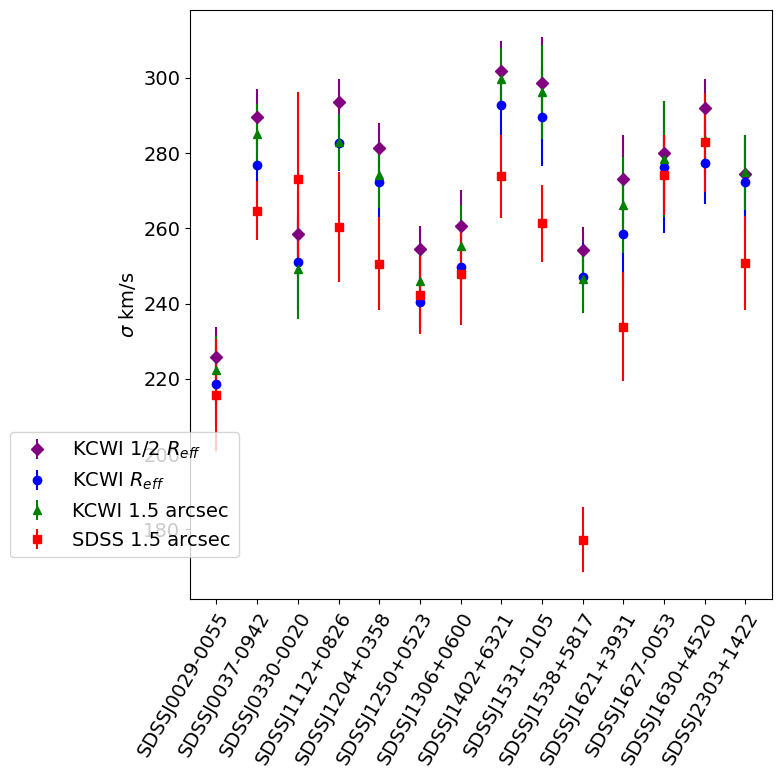

In [30]:
plt.rcParams.update({'font.size': 14})


plt.figure(figsize=(8,8))
x = range(14)
plt.errorbar(x, VD_half_reff[:], yerr=dVD_half_reff[:], c='purple', marker='D', linestyle='')
plt.errorbar(x, VD_reff[:], yerr=dVD_reff[:], c='b', marker='o', linestyle='')
plt.errorbar(x, VD_sdssap[:], yerr=dVD_sdssap[:], c='g', marker='^', linestyle='')
plt.errorbar(x, VD_slacs_asb, yerr=dVD_slacs_asb, c='r', marker='s', linestyle='')
plt.legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   bbox_to_anchor=(0.1,0.3))
plt.xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()
#plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_{date}.pdf', bbox_inches='tight')

In [31]:
reffs = paper_table['reff_slacs']

# Ratios and stuff

# Below I bring in the velocity dispersions taken by integrating the datacube within the 1.5 arcsec radius and convolving with the diffeerence betweene SDSS and KCWI seeing.
# This is what I will actually use for the paper

In [32]:
VD_sdssaps_data = np.array([211.26494656, 287.41197403, 257.32492182, 286.95007795,
                           268.09204097, 240.46467915, 239.0995199 , 285.49199042,
                           275.06075138, 250.26083351, 256.90938286, 268.09459787,
                           278.49342148, 278.39234733])
dVD_sdssaps_data = np.array([3.02051884, 2.32469061, 4.52272552, 3.25067286, 2.96761395,
                           2.63192579, 3.67940682, 2.4222208 , 4.60764371, 3.87149718,
                           4.4932315 , 3.98219001, 3.05359877, 3.67921924])

In [33]:
# import curve fit and define the power law to be fit
from scipy.optimize import curve_fit
import uncertainties.unumpy as unp
import uncertainties as unc

In [34]:
VD_ratios = np.ones_like( VD_ap_int_aptest )
dVD_ratios = np.ones_like(VD_ratios)

for i in range(14):
    # take the ratio of each velocity dispersion to the one at the effective radius
    for k in range(15):
        VD_ratio = VD_ap_int_aptest[i,k] / VD_ap_int_aptest[i,9] # ratio wrt where reff_factors = 1
        VD_ratios[i,k] = VD_ratio
        dVD_ratio = VD_ratio * np.sqrt((dVD_ap_int_aptest[i,k]/VD_ap_int_aptest[i,k])**2 \
                                       + (dVD_ap_int_aptest[i,9]/VD_ap_int_aptest[i,9])**2)
        dVD_ratios[i,k] = dVD_ratio
        # take the effective radius factors as the x axis

pl weighted fit: mean -0.03275784082987066


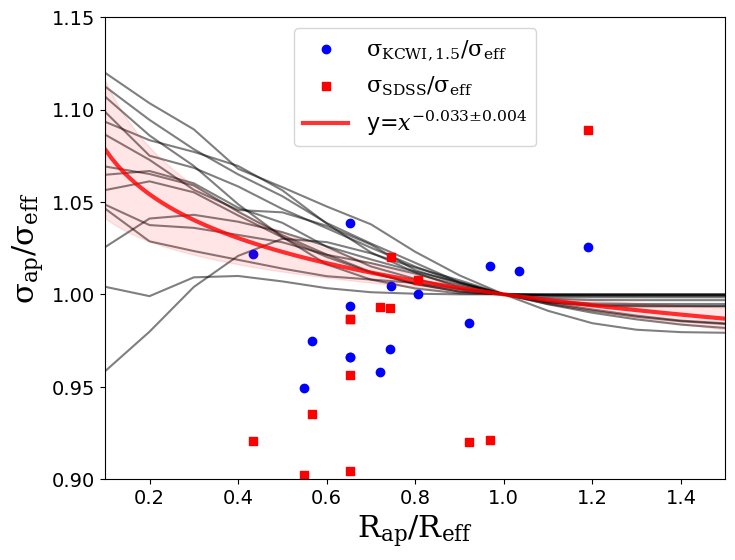

In [135]:
def power_law_fixed(x, a):
    return np.power(x, a)

# weighted
ps = np.zeros(14)
variances = np.zeros((14, 2))


aperture_ratios = 1.5/np.array(reffs)
sdssap_ratios = VD_sdssap[:]/VD_reff[:]
sdssap_ratios_data = VD_sdssaps_data[:]/VD_reff[:]
sdss_ratios = VD_slacs_asb/VD_reff[:]
dsdssap_ratios = sdssap_ratios * np.sqrt((dVD_sdssap[:]/VD_sdssap[:])**2 + (dVD_reff[:]/VD_reff[:])**2)
dsdssap_data_ratios = sdssap_ratios_data * np.sqrt((dVD_sdssaps_data[:]/VD_sdssaps_data[:])**2 + (dVD_reff[:]/VD_reff[:])**2)

fig, axs = plt.subplots(figsize=(8,6))#, gridspec_kw={'height_ratios': [4, 1]})
plt.subplots_adjust(hspace=0.25)
for i in range(14):
    # plot the data
    axs.plot(reff_factors, VD_ratios[i,:], c='k', alpha=0.5, zorder=-2)
    # weighted
    p, cov = curve_fit(f=power_law_fixed, xdata=reff_factors, ydata=VD_ratios[i,:], p0=[0], 
                       sigma=dVD_ratios[i,:], 
                       absolute_sigma=True,
                       bounds=(-np.inf, np.inf))
    ps[i] = p
    variances[i] = cov
    fit = power_law_fixed(reff_factors, p)
    #axs.plot(reff_factors, fit, c='r', linestyle=':', alpha=0.1)
    # plot the ratios of kcwi - 1.5 to reff
    if i==0:
        axs.scatter(aperture_ratios[i], sdssap_ratios_data[i],#, yerr=dsigma_ratios[i],
                        marker='o', c='b', label=r'$\mathrm{\sigma_{KCWI,1.5}/\sigma_{eff}}$')
        axs.scatter(aperture_ratios[i], sdss_ratios[i], marker='s', c='r', label=r'$\mathrm{\sigma_{SDSS}/\sigma_{eff}}$')
    #axs.scatter(aperture_ratios[i], sdssap_ratios[i],#, yerr=dsigma_ratios[i],
    #            marker='o', c='b')#, s=60)
    axs.scatter(aperture_ratios[i], sdssap_ratios_data[i],#, yerr=dsigma_ratios[i],
                marker='o', c='b')#, s=60)
    axs.scatter(aperture_ratios[i], sdss_ratios[i], marker='s', c='r')

# take the weighted mean of parameters for each fit # (weighted by inverse variance)
# weighted
mean = np.average(ps)#, weights=1/variances_w[:,0])
mean_var = np.average(variances)
mean_err = np.sqrt(mean_var/14)

print('pl weighted fit: mean', mean)

# plot the fit curve relation
x=np.linspace(0.1, 1.5, 100)
ac = unc.correlated_values(np.array([mean]), np.array([[mean_var]])) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = power_law_fixed(x, ac)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
gamma = f'{"{:.3f}".format(mean)}\u00B1{"{:.3f}".format(mean_err)}'
#print(gamma)
label = f'y=$x^{{{gamma}}}$'
plt.plot(x, nom, c='r', label=label, linewidth=3, alpha=0.8, zorder=-1)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

#mean_wfit = power_law_fixed(reff_factors, mean)
#mean_wfit_low = power_law_fixed(reff_factors, mean-mean_err)
#mean_wfit_hi = power_law_fixed(reff_factors, mean+mean_err)

#axs.plot(reff_factors, mean_wfit, c='b', linewidth=3, label=f'power law {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(np.sqrt(mean_var))}')
#axs.fill_between(reff_factors, mean_wfit_low, mean_wfit_hi, color='b', alpha=0.2)
#axs[0].plot(reff_factors, mean_mean_fit_low, linewidth=10)
#axs[1].axhline(mean_var0, 0, 1, c='b')         

axs.legend(loc='best', fontsize=16)
axs.set_xlim(0.1, 1.5)
axs.set_xlabel(r'$\mathrm{R_{ap}/R_{eff}}$', fontsize=22)
axs.set_ylabel(r'$\mathrm{\sigma_{ap}/\sigma_{eff}}$', fontsize=22)
#axs[1].set_xlim(0.1, 1.5)
axs.set_ylim(0.90, 1.15)
#axs[1].set_yticks(np.arange(0.0, 0.15, 0.05))

plt.savefig(f'{kinematics_dir}aperture_correction_power_law.png', bbox_inches='tight')
plt.savefig(f'{kinematics_dir}aperture_correction_power_law.pdf', bbox_inches='tight')

# I really couldn't care any less about this. ^^^ Move on.

# Plot the aperture-integrated velocity dispersions with ratio of 1.5 arcsec apertures (KCWI vs SDSS)

In [36]:
SDSS_ap_ratios = np.ones_like(VD_sdssap)
dSDSS_ap_ratios = np.ones_like(VD_sdssap)

for j in range(4):
    SDSS_ap_ratios[:] = VD_sdssap[:]/VD_slacs_asb
    dSDSS_ap_ratios[:] = SDSS_ap_ratios[:]*np.sqrt((dVD_sdssap[:]/VD_sdssap[:])**2+(dVD_slacs_asb/VD_slacs_asb)**2)

In [37]:
SDSS_ap_ratios_data = np.ones_like(VD_sdssap)
dSDSS_ap_ratios_data = np.ones_like(VD_sdssap)

for j in range(4):
    SDSS_ap_ratios_data[:] = VD_sdssaps_data[:]/VD_slacs_asb
    dSDSS_ap_ratios_data[:] = SDSS_ap_ratios_data[:]*np.sqrt((dVD_sdssaps_data[:]/VD_sdssaps_data[:])**2+(dVD_slacs_asb/VD_slacs_asb)**2)

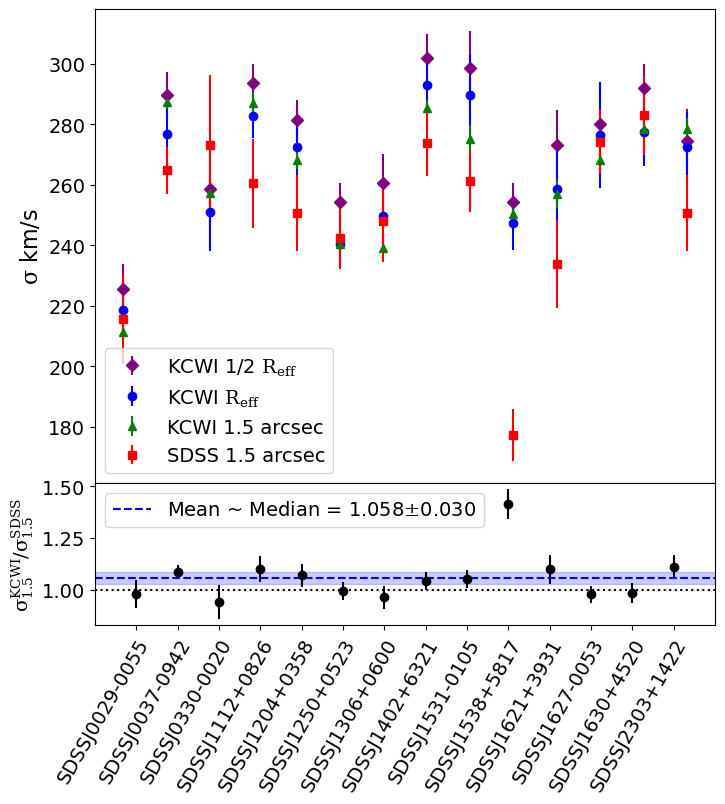

In [153]:
plt.rcParams.update({'font.size': 14})

mean = np.mean(SDSS_ap_ratios_data, axis=0)
err = np.std(SDSS_ap_ratios_data, axis=0)/np.sqrt(14)

fig, ax = plt.subplots(2,1,figsize=(8,8), gridspec_kw={'height_ratios': [10, 3]})
plt.subplots_adjust(hspace=0.0)

x = range(14)
ax[0].errorbar(x, VD_half_reff[:], yerr=dVD_half_reff[:], c='purple', marker='D', linestyle='')
ax[0].errorbar(x, VD_reff[:], yerr=dVD_reff[:], c='b', marker='o', linestyle='')
ax[0].errorbar(x, VD_sdssaps_data[:], yerr=dVD_sdssaps_data[:], c='g', marker='^', linestyle='')
ax[0].errorbar(x, VD_slacs_asb, yerr=dVD_slacs_asb, c='r', marker='s', linestyle='')
ax[0].legend([r'KCWI 1/2 $\mathrm{R_{eff}}$', 'KCWI $\mathrm{R_{eff}}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   loc='lower left')#bbox_to_anchor=(0.1,0.3))
#ax[0].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[0].set_ylabel(r'$\mathrm{\sigma}$ km/s', fontsize=16)
if j != 3:
    ax[0].set_title(f'Bin S/N {vorbin_SN_targets[j]}')
#ax[0].tight_layout()

x = np.linspace(-1, 15, 100)
ylo = np.ones_like(x)*(mean-err)
yhi = np.ones_like(x)*(mean+err)

for i in range(len(VD_slacs_asb)):
    ax[1].errorbar(i, SDSS_ap_ratios_data[i], yerr=dSDSS_ap_ratios_data[i], color='k', marker='o')
ax[1].set_ylabel(r'$\mathrm{{\sigma_{1.5''}^{KCWI}}/{\sigma_{1.5''}^{SDSS}}}$', fontsize=14)
ax[1].axhline(mean, 0, 1, color='b', linestyle='--', label=f'Mean ~ Median = {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(err)}')
ax[1].fill_between(x, 
                ylo,
               yhi,
               color='b',
               alpha=0.2)
ax[1].axhline(1.0, 0, 1, color='k', linestyle=':')
ax[1].set_xlim(-1, 14)
ax[1].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[1].legend(loc='upper left')
#ax[0].set_title(f'Bin S/N {vorbin_SN_targets[j]}')

plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.pdf', bbox_inches='tight')
plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.png', bbox_inches='tight')

(165.0, 315.0)

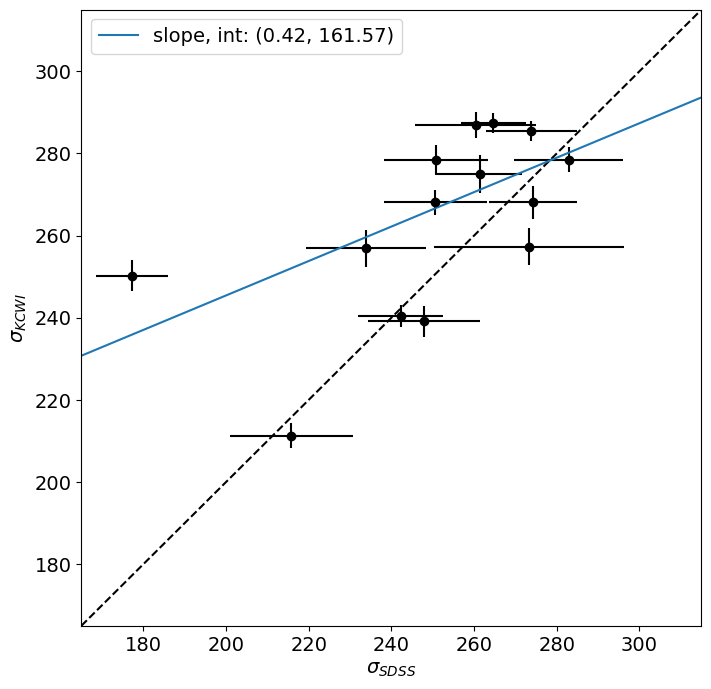

In [39]:
plt.figure(figsize=(8,8))
xx = np.linspace(165, 315, 100)
plt.errorbar(VD_slacs_asb, VD_sdssaps_data, xerr=dVD_slacs_asb, yerr = dVD_sdssaps_data, linestyle='None', c='k', marker='o')
plt.plot(xx, xx, '--', color='k')

# fit the line
p, cov = np.polyfit(VD_slacs_asb-250, VD_sdssaps_data-250,
                    deg=1,
                    w=1/np.sqrt(dVD_slacs_asb**2+dVD_sdssaps_data**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]

plt.plot(xx, m*(xx-250)+b+250, label=f'slope, int: {np.around(m, 2), np.around(b+250*(1 - m), 2) }')
plt.legend()
plt.xlim(165, 315)
plt.xlabel(r'$\sigma_{SDSS}$')
plt.ylabel(r'$\sigma_{KCWI}$')
plt.ylim(165, 315)

_____
# SLACS Relations
## log(sigma_{reff/2}) and log(M_*)
## gamma and f_SIE
## gamma and reff
## gamma and sigma_{reff/2}
## gamma and M_{reff/2} / {reff^-2} ??? Maybe not this one
## M_{reff/2} and M*


# Look at stellar masses from https://arxiv.org/pdf/1407.5633.pdf
## Take Mag_r, M/L_r from tables 1 and 2
## See how they split across M_* = 2e11 M_sun

In [40]:
# take the sdss r mag
r_mags = np.array([-22.79,
                  -23.20,
                  -22.93,
                  -23.02,
                   -22.16,
                   -23.11,
                   0.0,
                   -23.14,
                   -23.04,
                   -21.98,
                   -23.22,
                   -22.78,
                   -23.18,
                   -22.83
                  ])

# solar magnitude in sdss r
mag_sun_r = 4.64 # (Blanton & Roweis 2007)

# convert to luminosity
lum_rs = 10**(0.4*(mag_sun_r - r_mags)) # solar luminosities

# take the ml_MFL, logs
log_ml_rs = np.array([0.693,
                     0.665,
                     0.487,
                     0.793,
                     0.835,
                     0.548, 
                      -1.0,
                      0.706, 
                     0.728,
                     0.577,
                     0.571,
                     0.830,
                     0.671,
                     0.779])

# convert from log
ml_rs = 10**log_ml_rs

# multiply mass to light by the light to get mass
stellar_masses = ml_rs * lum_rs

stellar_masses

array([4.62381021e+11, 6.32411851e+11, 3.27340695e+11, 7.19448978e+11,
       3.58921935e+11, 4.44631267e+11, 7.17794291e+00, 6.57657837e+11,
       6.30957344e+11, 1.67880402e+11, 5.18800039e+11, 6.28058359e+11,
       6.29506183e+11, 5.84790084e+11])

In [41]:
# from https://ui.adsabs.harvard.edu/abs/2009ApJ...705.1099A/abstract
# stellar masses are in log
log_stellar_masses_salp = np.array([11.58,
                                   11.73,
                                   11.58,
                                   11.76,
                                   11.45,
                                   11.77,
                                   11.43,
                                   11.79,
                                   11.68,
                                   11.28,
                                   11.70,
                                   11.70,
                                   11.86,
                                   11.71]) 

dlog_stellar_masses_salp = np.array([0.13,
                                    0.06,
                                    0.09,
                                    0.08,
                                    0.06,
                                    0.07,
                                    0.08,
                                    0.06,
                                    0.09,
                                    0.08,
                                    0.07,
                                    0.09,
                                    0.07,
                                    0.06])

# take from log
stellar_masses_salp = 10**log_stellar_masses_salp

# convert to scientific notation
for i in range(len(stellar_masses_salp)):
    sci = np.format_float_scientific(stellar_masses_salp[i])
    stellar_masses_salp[i] = sci

stellar_masses_salp

array([3.80189396e+11, 5.37031796e+11, 3.80189396e+11, 5.75439937e+11,
       2.81838293e+11, 5.88843655e+11, 2.69153480e+11, 6.16595002e+11,
       4.78630092e+11, 1.90546072e+11, 5.01187234e+11, 5.01187234e+11,
       7.24435960e+11, 5.12861384e+11])

In [42]:
zlens = paper_table['zlens'].to_numpy()

In [43]:
import astropy.constants as c
import astropy.units as u

In [44]:
G_unit = c.G.to(u.kpc * u.km**2 / u.M_sun / u.s**2)

In [45]:
G_unit

<Quantity 4.30091727e-06 km2 kpc / (s2 solMass)>

In [46]:
# first take sigma_1/2 and the slacs-adjusted value from sigma_sdss

def VD_half_reff_from_sdss(VD_sdss, dVD_sdss, reff):
    '''
    This is the relation I derive from the power law fit to my KCWI measurements
    VD_sdss is the input 1.5 arcsec aperture velocity disperion
    error
    effective radius in arcsec
    '''
    # this is the gamma I get from the power law fit
    gamma = -0.033
    
    # reff/3 comes from the Reff/2 /1.5
    VD_half_reff = VD_sdss * np.power(reff/3, gamma)
    dVD_half_reff = dVD_sdss * np.power(reff/3, gamma)
    
    return VD_half_reff, dVD_half_reff

# function for calculating dynamical mass from SLACS X

def dynamical_mass_half_reff(reff_kpc, VD_half_reff, dVD_half_reff):
    
    'Virial estimate following prescription from slacs x'
    
    if reff_kpc.shape != VD_half_reff.shape:
        num = VD_half_reff.shape[1]
        reff_kpc = np.swapaxes(np.tile(reffs_kpc, (num,1)), 0 , 1) # will make a new array with three iterations of reff_kpc
    
    cv = 10**0.53 # virial coefficient fit SLACS X
    # G unit is the value of G in km2kpc/M⊙s2
    M_half_reff = (cv * reff_kpc * VD_half_reff**2) / (2 * G_unit.value)
    dM_half_reff = (2*dVD_half_reff/VD_half_reff) * M_half_reff
    return M_half_reff, dM_half_reff


In [47]:
# calculate half-reff velocity dispersions for updated SLACS info from Bolton
VD_sdss = np.array(VD_slacs_asb)#[not_na])
dVD_sdss = np.array(dVD_slacs_asb)#[not_na])

# use  slacs effective radii
#reffs = reffs#[not_na]
reffs_kpc = cosmo.angular_diameter_distance(zlens).to(u.kpc)*reffs/206265

# get half-reff velocity dispersions
VD_half_reff_sdss, dVD_half_reff_sdss = VD_half_reff_from_sdss(VD_sdss, dVD_sdss, reffs)
# take the kcwi info
VD_half_reff_kcwi = VD_half_reff#[not_na]
dVD_half_reff_kcwi = dVD_half_reff#[not_na]
# take logs
log_VD_half_reff_sdss = np.log10(VD_half_reff_sdss)
dlog_VD_half_reff_sdss = dVD_half_reff_sdss/VD_half_reff_sdss * 1/np.log(10)
log_VD_half_reff_kcwi = np.log10(VD_half_reff_kcwi)
dlog_VD_half_reff_kcwi = dVD_half_reff_kcwi/VD_half_reff_kcwi * 1/np.log(10)

# take log stellar masses from SLACS IX
log_stellar_masses = log_stellar_masses_salp#[not_na]-11 # they normalized inside the log to 10^11 solar masses
dlog_stellar_masses = dlog_stellar_masses_salp#[not_na]

# calculate dynamical mass within half effecitve radius
Mdyn_half_reff_kcwi, dMdyn_half_reff_kcwi = dynamical_mass_half_reff(reffs_kpc, VD_half_reff_kcwi, dVD_half_reff_kcwi)
Mdyn_half_reff_sdss, dMdyn_half_reff_sdss = dynamical_mass_half_reff(reffs_kpc, VD_half_reff_sdss, dVD_half_reff_sdss)
# logs
log_Mdyn_half_reff_kcwi = np.log10(Mdyn_half_reff_kcwi)
dlog_Mdyn_half_reff_kcwi = np.array(dMdyn_half_reff_kcwi/Mdyn_half_reff_kcwi) * 1/np.log(10)
dlog_Mdyn_half_reff_kcwi = np.array(dlog_Mdyn_half_reff_kcwi)
log_Mdyn_half_reff_sdss = np.log10(Mdyn_half_reff_sdss)
dlog_Mdyn_half_reff_sdss = np.array(dMdyn_half_reff_sdss/Mdyn_half_reff_sdss) * 1/np.log(10)
dlog_Mdyn_half_reff_sdss = np.array(dlog_Mdyn_half_reff_sdss)

In [48]:
Mdyn_half_reff_kcwi

0     1.678782e+11
1     2.456106e+11
2     1.641078e+11
3     2.194098e+11
4     1.431721e+11
5     1.753838e+11
6     1.636917e+11
7     3.200557e+11
8     2.645473e+11
9     9.267800e+10
10    2.603173e+11
11    2.124277e+11
12    2.623701e+11
13    2.755848e+11
Name: reff_slacs, dtype: float64

In [49]:
slacs_x_data = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data.txt', delimiter='')
slacs_x_names = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data_names.txt', delimiter='', dtype='U15')
# make a dataframe
slacs_x = pd.DataFrame(slacs_x_data,
                      columns=['obj_name',
                              'reff_kpc',
                              'VD_half_reff',
                              'dVD_half_reff',
                              'log_stellar_mass_chab',
                              'dlog_stellar_mass_chab',
                              'log_stellar_mass_salp',
                              'dlog_stellar_mass_salp',
                              'log_M_half_reff',
                              'dlog_M_half_reff',
                              'fdm_chab',
                              'dfdm_chab',
                               'fdm_salp',
                               'dfdm_salp',
                               'gamma',
                               'dgamma'
                              ])
slacs_x['obj_name']=slacs_x_names

slacs_x['log_VD_half_reff'] = np.log10(slacs_x['VD_half_reff'])
slacs_x['dlog_VD_half_reff'] = 1/np.log(10) * slacs_x['dVD_half_reff']/slacs_x['VD_half_reff']

In [50]:
slacs_x_names

array(['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0044+0113',
       'SDSSJ0216-0813', 'SDSSJ0252+0039', 'SDSSJ0330-0020',
       'SDSSJ0728+3835', 'SDSSJ0737+3216', 'SDSSJ0819+4534',
       'SDSSJ0822+2652', 'SDSSJ0912+0029', 'SDSSJ0935-0003',
       'SDSSJ0936+0913', 'SDSSJ0946+1006', 'SDSSJ0956+5100',
       'SDSSJ0959+0410', 'SDSSJ0959+4416', 'SDSSJ1016+3859',
       'SDSSJ1020+1122', 'SDSSJ1023+4230', 'SDSSJ1029+0420',
       'SDSSJ1106+5228', 'SDSSJ1112+0826', 'SDSSJ1134+6027',
       'SDSSJ1142+1001', 'SDSSJ1143-0144', 'SDSSJ1153+4612',
       'SDSSJ1204+0358', 'SDSSJ1205+4910', 'SDSSJ1213+6708',
       'SDSSJ1218+0830', 'SDSSJ1250+0523', 'SDSSJ1306+0600',
       'SDSSJ1313+4615', 'SDSSJ1318-0313', 'SDSSJ1330-0148',
       'SDSSJ1402+6321', 'SDSSJ1403+0006', 'SDSSJ1416+5136',
       'SDSSJ1420+6019', 'SDSSJ1430+4105', 'SDSSJ1436-0000',
       'SDSSJ1443+0304', 'SDSSJ1451-0239', 'SDSSJ1525+3327',
       'SDSSJ1531-0105', 'SDSSJ1538+5817', 'SDSSJ1614+4522',
       'SDSSJ1621+3931',

# Some of SLACS X sample is not included in their correlations analysis.
We find that 6 galaxies in our
sample are significant outliers of the hyper-plane relation between size, velocity dispersion, stellar mass, and
total mass given by Equation 3 (these systems are indicated in Table 1). We have investigated the nature of
these outliers but find that they generally do not stand
out from the other lensing galaxies; none of these discrepant objects have disky structure, nor do they have
anomalous spectral features. Furthermore, we have determined the stellar velocity dispersions for each object
using three independent codes but the codes do not find
a significant difference between these six objects and the
others. Nevertheless, we use an abundance of caution
and exclude these six objects from the fits that include
intrinsic scatter, as these objects tend to dominate those
relations.
## One of these is J0029!

In [51]:
# indices that were excluded 0,7,8,11,29,47

filter_indices = [0,7,8,11,29,47]
no_anal = np.ones(len(slacs_x), dtype=bool) # no analysis :)
no_anal[filter_indices] = 0
print(no_anal)
slacs_x.iloc[no_anal]

[False  True  True  True  True  True  True False False  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True]


,obj_name,reff_kpc,VD_half_reff,dVD_half_reff,log_stellar_mass_chab,dlog_stellar_mass_chab,log_stellar_mass_salp,dlog_stellar_mass_salp,log_M_half_reff,dlog_M_half_reff,fdm_chab,dfdm_chab,fdm_salp,dfdm_salp,gamma,dgamma,log_VD_half_reff,dlog_VD_half_reff
1,SDSSJ0037-0942,7.44,282.0,10.0,11.48,0.06,11.73,0.06,11.36,0.02,0.57,0.07,0.25,0.11,2.14,0.07,2.450249,0.015401
2,SDSSJ0044+0113,6.12,267.0,13.0,11.23,0.09,11.47,0.09,11.13,0.07,0.59,0.10,0.29,0.18,2.31,0.24,2.426511,0.021145
3,SDSSJ0216-0813,13.19,334.0,23.0,11.79,0.07,12.03,0.07,11.76,0.02,0.65,0.06,0.40,0.11,2.09,0.20,2.523746,0.029907
4,SDSSJ0252+0039,5.68,170.0,12.0,11.21,0.13,11.46,0.13,10.97,0.03,0.42,0.18,-0.03,0.32,1.57,0.12,2.230449,0.030656
5,SDSSJ0330-0020,6.23,220.0,21.0,11.35,0.09,11.58,0.09,11.14,0.05,0.46,0.12,0.09,0.21,1.91,0.18,2.342423,0.041455
6,SDSSJ0728+3835,5.86,219.0,11.0,11.44,0.12,11.69,0.12,11.12,0.02,0.31,0.19,-0.23,0.37,1.86,0.10,2.340444,0.021814
9,SDSSJ0822+2652,7.64,263.0,15.0,11.43,0.13,11.69,0.13,11.32,0.02,0.56,0.13,0.21,0.23,2.12,0.14,2.419956,0.024770
10,SDSSJ0912+0029,11.69,322.0,12.0,11.71,0.07,11.96,0.07,11.71,0.02,0.67,0.06,0.43,0.09,1.98,0.09,2.507856,0.016185
12,SDSSJ0936+0913,7.00,246.0,11.0,11.43,0.12,11.68,0.12,11.18,0.02,0.40,0.17,-0.07,0.30,2.24,0.12,2.390935,0.019420
13,SDSSJ0946+1006,9.08,265.0,21.0,11.34,0.12,11.59,0.12,11.43,0.02,0.73,0.07,0.51,0.14,2.01,0.18,2.423246,0.034416


# plot log sigma_reff/2 to log stellar mass
# velocity dispersion in units km/s and stellar mass in units 10^11 solar masses

In [52]:
obj_names

['SDSSJ0029-0055',
 'SDSSJ0037-0942',
 'SDSSJ0330-0020',
 'SDSSJ1112+0826',
 'SDSSJ1204+0358',
 'SDSSJ1250+0523',
 'SDSSJ1306+0600',
 'SDSSJ1402+6321',
 'SDSSJ1531-0105',
 'SDSSJ1538+5817',
 'SDSSJ1621+3931',
 'SDSSJ1627-0053',
 'SDSSJ1630+4520',
 'SDSSJ2303+1422']

In [53]:
# make a directory for slacsx analysis in the kinematics dir
from pathlib import Path

Path(f'{kinematics_dir}slacs_x_analysis/').mkdir(parents=True, exist_ok=True)

mean std,  0.03978965944541422
my calculation:  0.16824565155063229 0.0418098192590259 2.3027926868014705 0.025702390930690877
slacs x values:  0.18 0.03 2.34 0.01


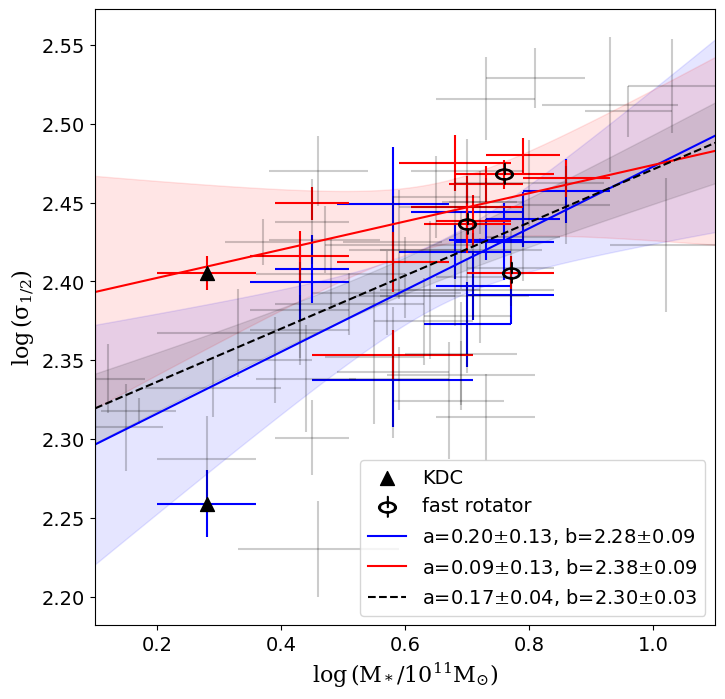

In [157]:
# log stellar masses from SLACS IX

fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(log_stellar_masses-11, log_VD_half_reff_sdss,
            xerr=dlog_stellar_masses, yerr=dlog_VD_half_reff_sdss, 
             color='b',
            linestyle='')
axs.errorbar(log_stellar_masses-11, log_VD_half_reff_kcwi[:],
            xerr=dlog_stellar_masses, yerr=dlog_VD_half_reff_kcwi[:], 
             color='r',
            linestyle='')
axs.errorbar(slacs_x.loc[no_anal,'log_stellar_mass_salp']-11, slacs_x.loc[no_anal,'log_VD_half_reff'],
            xerr=slacs_x.loc[no_anal,'dlog_stellar_mass_salp'], yerr=slacs_x.loc[no_anal,'dlog_VD_half_reff'], 
             color='k',
            #marker='.',
            linestyle='',
            alpha=0.2
            )
kdc = 9
axs.scatter(log_stellar_masses[kdc]-11, log_VD_half_reff_kcwi[kdc], c='k', marker='^', facecolor='None', s=100, zorder=10, label='KDC', )
axs.scatter(log_stellar_masses[kdc]-11, log_VD_half_reff_sdss[kdc], c='k', marker='^', facecolor='None', s=100, zorder=10)#, label='KDC', )
# plot the symbols for the class distinctions
for i in range(len(obj_names)):
    fs = classes[i]#classifications.loc[i,'lambda_R_class']
    if fs == 'slow':
        #marker = nonregular
        #s = 80
        continue
    elif fs == 'fast':
        marker = rotator
        s = 250
        #plt.scatter(log_Mdyn_half_reff_sdss[i], log_stellar_masses[i], marker=marker, c='k', s=s, zorder=10)
        if i == 3:
            label='fast rotator'
        else:
            label='_nolegend_'
        plt.scatter(log_stellar_masses[i]-11, log_VD_half_reff_kcwi[i], marker=marker, c='k', s=s, zorder=10, label=label)

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(log_stellar_masses-11, log_VD_half_reff_sdss,
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_sdss**2+dlog_stellar_masses**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

# fit a line to kcwi data
p, cov = np.polyfit(log_stellar_masses-11, log_VD_half_reff_kcwi[:],
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_kcwi[:]**2+dlog_stellar_masses**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
print('mean std, ', np.mean(std))
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

# slacs x lines
# a = 0.18±0.03, b = 2.34±0.01
# do a fit and see if it's the same
p, cov = np.polyfit(slacs_x.loc[no_anal,'log_stellar_mass_salp']-11, slacs_x.loc[no_anal,'log_VD_half_reff'],
                    deg=1,
                    w=1/np.sqrt(slacs_x.loc[no_anal,'dlog_stellar_mass_salp']**2+slacs_x.loc[no_anal,'dlog_VD_half_reff']**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
print('my calculation: ', m, merr, b, berr)
m_x = 0.18
merr_x = 0.03
b_x = 2.34
berr_x = 0.01
print('slacs x values: ', m_x, merr_x, b_x, berr_x)
x = np.linspace(0.1, 1.1,100)
#p = np.array([m,b])
#cov = np.array([[merr, 0],
#              [0, berr]]) # no info on the covriance
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='k', linestyle='--', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

axs.set_xlim(0.1, 1.1)
label_fontsize=16
axs.set_xlabel(r'$\mathrm{\log\left(M_*/10^{11}M_{\odot}\right)}$', fontsize=label_fontsize)
axs.set_ylabel(r'$\mathrm{\log\left(\sigma_{1/2}\right)}$', fontsize=label_fontsize)
handles, labels = axs.get_legend_handles_labels()
axs.legend(loc='lower right')

plt.savefig(f'{kinematics_dir}slacs_x_analysis/VD_half_reff_vs_log_stellar_mass.pdf', bbox_inches='tight')

## plot without KDC

In [55]:
no_anal_no_kdc = no_anal & (slacs_x_names != 'SDSSJ1538+5817')

In [56]:
no_kdc = log_VD_half_reff_sdss > np.nanmin(log_VD_half_reff_sdss)

mean std,  0.03978965944541422
my calculation:  0.16824565155063229 0.0418098192590259 2.3027926868014705 0.025702390930690877
slacs x values:  0.18 0.03 2.34 0.01
mean std,  0.04830716200449973
my calculation:  0.16396036553353469 0.04219885505617786 2.306330060954614 0.026132024159053108
slacs x values:  0.18 0.03 2.34 0.01


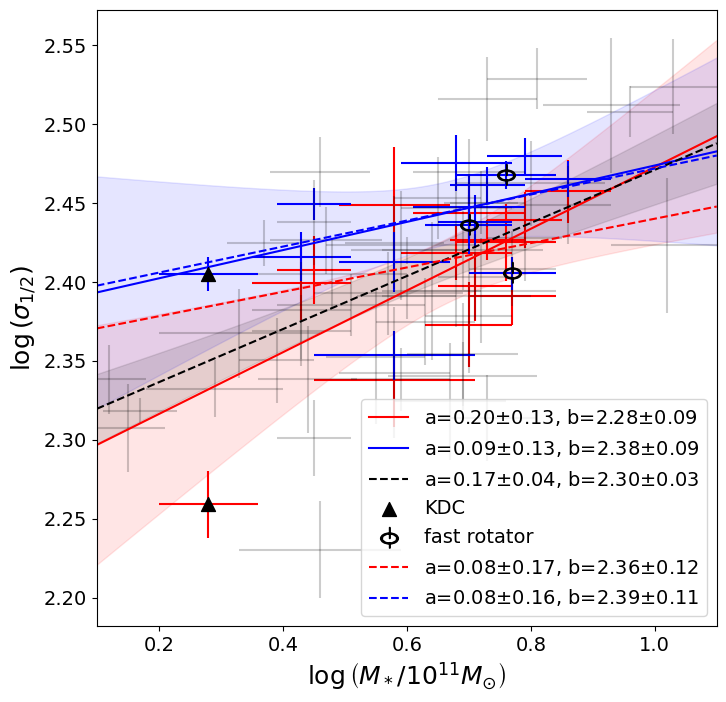

In [57]:
# log stellar masses from SLACS IX


fig, axs = plt.subplots(figsize=(8,8))

index = no_kdc

axs.errorbar(log_stellar_masses[index]-11, log_VD_half_reff_sdss[index],
            xerr=dlog_stellar_masses[index], yerr=dlog_VD_half_reff_sdss[index], 
             color='r',
            linestyle='')
axs.errorbar(log_stellar_masses[index]-11, log_VD_half_reff_kcwi[index],
            xerr=dlog_stellar_masses[index], yerr=dlog_VD_half_reff_kcwi[index], 
             color='b',
            linestyle='')
axs.errorbar(slacs_x.loc[no_anal_no_kdc,'log_stellar_mass_salp']-11, slacs_x.loc[no_anal_no_kdc,'log_VD_half_reff'],
            xerr=slacs_x.loc[no_anal_no_kdc,'dlog_stellar_mass_salp'], yerr=slacs_x.loc[no_anal_no_kdc,'dlog_VD_half_reff'], 
             color='k',
            #marker='.',
            linestyle='',
            alpha=0.2
            )

# plot fit including the kdc
# fit a line to sdss data
# fit a line
p, cov = np.polyfit(log_stellar_masses-11, log_VD_half_reff_sdss,
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_sdss**2+dlog_stellar_masses**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label, linestyle='-')
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

# fit a line to kcwi data
p, cov = np.polyfit(log_stellar_masses-11, log_VD_half_reff_kcwi[:],
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_kcwi[:]**2+dlog_stellar_masses**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
print('mean std, ', np.mean(std))
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label, linestyle='-')
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

# slacs x lines
# a = 0.18±0.03, b = 2.34±0.01
# do a fit and see if it's the same
p, cov = np.polyfit(slacs_x.loc[no_anal,'log_stellar_mass_salp']-11, slacs_x.loc[no_anal,'log_VD_half_reff'],
                    deg=1,
                    w=1/np.sqrt(slacs_x.loc[no_anal,'dlog_stellar_mass_salp']**2+slacs_x.loc[no_anal,'dlog_VD_half_reff']**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
print('my calculation: ', m, merr, b, berr)
m_x = 0.18
merr_x = 0.03
b_x = 2.34
berr_x = 0.01
print('slacs x values: ', m_x, merr_x, b_x, berr_x)
x = np.linspace(0.1, 1.1,100)
#p = np.array([m,b])
#cov = np.array([[merr, 0],
#              [0, berr]]) # no info on the covriance
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='k', linestyle='--', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

#####################################################################################################################################################################

# plot fit without the kdc

# plot the kdc separately
kdc = 9
axs.scatter(log_stellar_masses[kdc]-11, log_VD_half_reff_kcwi[kdc], c='k', marker='^', facecolor='None', s=100, zorder=10, label='KDC', )
axs.scatter(log_stellar_masses[kdc]-11, log_VD_half_reff_sdss[kdc], c='k', marker='^', facecolor='None', s=100, zorder=10)#, label='KDC', )
axs.errorbar(log_stellar_masses[kdc]-11, log_VD_half_reff_sdss[kdc],
            xerr=dlog_stellar_masses[kdc], yerr=dlog_VD_half_reff_sdss[kdc], 
             color='r',
            linestyle='')
axs.errorbar(log_stellar_masses[kdc]-11, log_VD_half_reff_kcwi[kdc],
            xerr=dlog_stellar_masses[kdc], yerr=dlog_VD_half_reff_kcwi[kdc], 
             color='b',
            linestyle='')

# plot the symbols for the class distinctions
for i in range(len(obj_names)):
    fs = classes[i]#classifications.loc[i,'lambda_R_class']
    if fs == 'slow':
        #marker = nonregular
        #s = 80
        continue
    elif fs == 'fast':
        marker = rotator
        s = 250
        #plt.scatter(log_Mdyn_half_reff_sdss[i], log_stellar_masses[i], marker=marker, c='k', s=s, zorder=10)
        if i == 3:
            label='fast rotator'
        else:
            label='_nolegend_'
        plt.scatter(log_stellar_masses[i]-11, log_VD_half_reff_kcwi[i], marker=marker, c='k', s=s, zorder=10, label=label)


# fit a line to sdss data
# fit a line
p, cov = np.polyfit(log_stellar_masses[index]-11, log_VD_half_reff_sdss[index],
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_sdss[index]**2+dlog_stellar_masses[index]**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label, linestyle='--')
# uncertainty lines (95% confidence)
#plt.fill_between(x, nom - std, nom + std,
 #                color='b',
 #                alpha=0.1#,\
         #label='95% Confidence Region'
 #               )

# fit a line to kcwi data
p, cov = np.polyfit(log_stellar_masses[index]-11, log_VD_half_reff_kcwi[index],
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_kcwi[index]**2+dlog_stellar_masses[index]**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
print('mean std, ', np.mean(std))
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label, linestyle='--')
# uncertainty lines (95% confidence)
#plt.fill_between(x, nom - std, nom + std,
   #              color='r',
   #              alpha=0.1#,\
    #     #label='95% Confidence Region'
     #           )

# slacs x lines
# a = 0.18±0.03, b = 2.34±0.01
# do a fit and see if it's the same
p, cov = np.polyfit(slacs_x.loc[no_anal_no_kdc,'log_stellar_mass_salp']-11, slacs_x.loc[no_anal_no_kdc,'log_VD_half_reff'],
                    deg=1,
                    w=1/np.sqrt(slacs_x.loc[no_anal_no_kdc,'dlog_stellar_mass_salp']**2+slacs_x.loc[no_anal_no_kdc,'dlog_VD_half_reff']**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
print('my calculation: ', m, merr, b, berr)
m_x = 0.18
merr_x = 0.03
b_x = 2.34
berr_x = 0.01
print('slacs x values: ', m_x, merr_x, b_x, berr_x)
x = np.linspace(0.1, 1.1,100)
#p = np.array([m,b])
#cov = np.array([[merr, 0],
#              [0, berr]]) # no info on the covriance
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
#plt.plot(x, nom, c='k', linestyle='--', label=label)
# uncertainty lines (95% confidence)
#plt.fill_between(x, nom - std, nom + std,
#                 color='k',
#                 alpha=0.1#,\
         #label='95% Confidence Region'
#                )

axs.set_xlim(0.1, 1.1)
label_fontsize=18
axs.set_xlabel(r'$\log\left(M_*/10^{11}M_{\odot}\right)$', fontsize=label_fontsize)
axs.set_ylabel(r'$\log\left(\sigma_{1/2}\right)$', fontsize=label_fontsize)
axs.legend()

#plt.savefig(f'{kinematics_dir}slacs_x_analysis/VD_half_reff_vs_log_stellar_mass.pdf', bbox_inches='tight')

# Plot log(M*) to log(M_{reff/2})
# units both in 10^10 solar masses

my calculation:  0.7987499560150939 0.035424758636560146 0.6073836341635676 0.043662983847400874
slacs x values:  0.81 0.03 2.362500439849061 0.3026549190084311


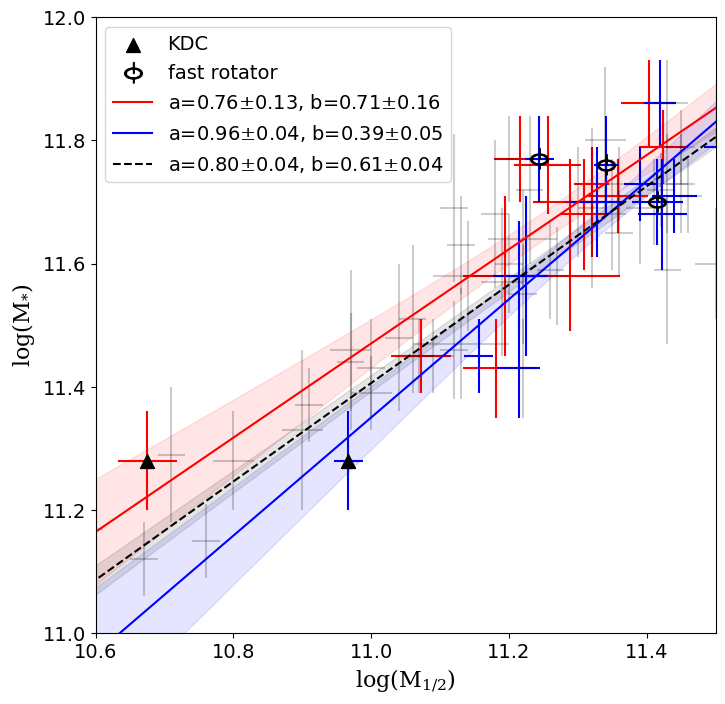

In [158]:

fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(log_Mdyn_half_reff_sdss, log_stellar_masses,
            xerr=dlog_Mdyn_half_reff_sdss, yerr=dlog_stellar_masses, 
             color='r',
            linestyle='')
axs.errorbar(log_Mdyn_half_reff_kcwi, log_stellar_masses,
            xerr=dlog_Mdyn_half_reff_kcwi, yerr=dlog_stellar_masses, 
             color='b',
            linestyle='')
axs.errorbar(slacs_x.loc[no_anal,'log_M_half_reff'], slacs_x.loc[no_anal,'log_stellar_mass_salp'],
            xerr=slacs_x.loc[no_anal,'dlog_M_half_reff'], yerr=slacs_x.loc[no_anal,'dlog_stellar_mass_salp'], 
             color='k',
            #marker='.',
            linestyle='',
            alpha=0.2
            )
kdc = 9
axs.scatter(log_Mdyn_half_reff_sdss[kdc], log_stellar_masses[kdc], c='k', marker='^', facecolor='None', s=100, zorder=10, label='KDC', )
axs.scatter(log_Mdyn_half_reff_kcwi[kdc], log_stellar_masses[kdc], c='k', marker='^', facecolor='None', s=100, zorder=10)#, label='KDC', )
# plot the symbols for the class distinctions
for i in range(len(obj_names)):
    fs = classes[i]
    if fs == 'slow':
        #marker = nonregular
        #s = 80
        continue
    elif fs == 'fast':
        marker = rotator
        s = 250
        #plt.scatter(log_Mdyn_half_reff_sdss[i], log_stellar_masses[i], marker=marker, c='k', s=s, zorder=10)
        if i == 3:
            label='fast rotator'
        else:
            label='_nolegend_'
        plt.scatter(log_Mdyn_half_reff_kcwi[i], log_stellar_masses[i], marker=marker, c='k', s=s, zorder=10, label=label)

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(log_Mdyn_half_reff_sdss-10, log_stellar_masses-10,
                    deg=1,
                    w=1/np.sqrt(dlog_Mdyn_half_reff_sdss**2+dlog_stellar_masses**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
x = np.linspace(10.5,11.5, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc + 10 * (1 - ac)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)

# fit a line to kcwi data
p, cov = np.polyfit(log_Mdyn_half_reff_kcwi-10, log_stellar_masses-10, 
                    deg=1,
                    w=1/np.sqrt(dlog_Mdyn_half_reff_kcwi**2+dlog_stellar_masses**2),
                    cov='unscaled'
                   )
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
x = np.linspace(10.5,11.5,100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc + 10 * (1 - ac)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std, 
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

# slacs x lines
# a = 0.18±0.03, b = 2.34±0.01
# do a fit and see if it's the same
p, cov = np.polyfit(slacs_x.loc[no_anal,'log_M_half_reff']-10, slacs_x.loc[no_anal,'log_stellar_mass_salp']-10,
                    deg=1,
                    w=1/np.sqrt(slacs_x.loc[no_anal,'dlog_stellar_mass_salp']**2+slacs_x.loc[no_anal,'dlog_M_half_reff']**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]
print('my calculation: ', m, merr, b, berr)
m_x = 0.81
merr_x = 0.03
bb_x = 0.35
bberr_x = 0.04
b_x = (1-m)*10 + bb_x
berr_x = np.sqrt((10*merr_x)**2+bberr_x**2)
print('slacs x values: ', m_x, merr_x, b_x, berr_x)
x = np.linspace(10.5,11.5,100)
#p = np.array([m,b])
#cov = np.array([[merr, 0],
#              [0, berr]]) # no info on the covriance
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc + 10 * (1 - ac)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses)) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='k', linestyle='--', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std, 
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
axs.set_xlabel(r'$\rm{\log(M_{1/2})}$', fontsize=label_fontsize)
axs.set_ylabel(r'$\rm{\log(M_{*})}$', fontsize=label_fontsize)
axs.set_xlim(10.6,11.5)
axs.set_ylim(11.0,12.0)
axs.legend()

plt.savefig(f'{kinematics_dir}slacs_x_analysis/log_stellar_mass_vs_log_M_half_reff.pdf', bbox_inches='tight')

# Need gamma and einstein radii from Shajib 2020 https://arxiv.org/pdf/2008.11724.pdf
# Then calculate the SIE velocity dispersion as $\sigma_{SIE}= c/2 \sqrt{\theta_E/\pi D_{LS}/D_S}$
# Redshifts from SLACS IX

In [59]:
classifications_table = pd.read_csv('/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/classifications_etc_032723.csv')
zsource = classifications_table['zsource']

# Bring in SLACS IX data from table

In [60]:
slacs_ix_redshifts = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_ix_redshifts.txt', skip_header=True, 
                                   delimiter='', dtype='U15')
slacs_ix_reins = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_ix_einstein_radii_kpc.txt', skip_header=True, 
                                   delimiter='', dtype='U15')

# make a dataframe
slacs_ix_z = pd.DataFrame(slacs_ix_redshifts,
                       columns=['obj_name','zlens','zsource']
                       )
slacs_ix_z.zlens = slacs_ix_z.zlens.astype(float)
slacs_ix_z.zsource = slacs_ix_z.zsource.astype(float)

# make another dataframe
slacs_ix_rein = pd.DataFrame(slacs_ix_reins,
                       columns=['obj_name','rein_kpc'],
                            )
slacs_ix_rein.rein_kpc = slacs_ix_rein.rein_kpc.astype(float)

# merge the dataframes
slacs_ix = pd.merge(slacs_ix_z, slacs_ix_rein, how='left', on='obj_name')

In [61]:
# gammas
gammas = np.array([2.47,
                 2.18,
                 2.16,
                 2.21,
                 2.19,
                 1.91,
                 2.18,
                 2.24,
                 1.90,
                 np.nan,
                 2.01,
                 1.84,
                 2.00,
                 2.00
                 ])
dgammas = np.array([0.08,
                     0.04,
                     0.02,
                     0.06,
                     0.06,
                     0.06,
                     0.06,
                     0.07,
                     0.12,
                     np.nan,
                     0.06,
                     0.14,
                     0.03,
                     0.05
                     ])

# einstein radii
reins = np.array([0.951,
                1.509,
                1.077,
                1.421,
                 1.285,
                 1.115,
                 1.299,
                 1.354,
                 1.705,
                 np.nan,
                 1.263,
                 1.227,
                 1.788,
                 1.529
                ])
dreins = np.array([0.003,
                  0.020,
                  0.005,
                  0.015,
                  0.005,
                  0.004,
                  0.012,
                  0.003,
                  0.009,
                 np.nan,
                  0.005,
                  0.002,
                  0.006,
                  0.005
                  ])

# index for the one that doesn't have a lens model (in Shajib 2020)
no_lens = np.isfinite(reins)
#nnnl = not_na & no_lens # I'm not doing the same indexing I did before (removing J0330 I think)
nnnl = no_lens

def VD_sie_from_rein_redshifts(rein, drein, zlens, zsource):
    
    DS = cosmo.angular_diameter_distance(zsource)
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource)
    
    c_kms = c.c.to(u.km/u.s).value
    rein_rad = rein/206265    
    
    VD_sie = c_kms/2 * np.sqrt((rein_rad/np.pi)*(DS/DLS))
    dVD_sie = VD_sie * 1/2 * drein / rein # the ratio will take care of the unit change
    
    return(VD_sie, dVD_sie)

def VD_sie_from_rein_kpc_redshifts(rein_kpc, zlens, zsource):
    
    DS = cosmo.angular_diameter_distance(zsource)
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource)
    DL = cosmo.angular_diameter_distance(zlens)
    
    c_kms = c.c.to(u.km/u.s).value
    rein_rad = rein_kpc/(DL*1000) #Mpc to kpc # already in radians
    
    # assume some kind of uncertainty here... 5% ?
    drein = 0.05 * rein_rad
    
    VD_sie = c_kms/2 * np.sqrt((rein_rad/np.pi)*(DS/DLS))
    dVD_sie = VD_sie * 1/2 * drein / rein_rad # I know this is redundant
    
    return(VD_sie, dVD_sie)

def f_sie_from_VDs(VD_half_reff, dVD_half_reff, VD_sie, dVD_sie):
    
    if VD_sie.shape != VD_half_reff.shape:
        num = VD_half_reff.shape[1]
        VD_sie = np.swapaxes(np.tile(VD_sie, (num,1)), 0 , 1) # makes teh arrays the right size by copying it num times
        dVD_sie = np.swapaxes(np.tile(dVD_sie, (num,1)), 0 , 1) 
    
    f_sie = VD_half_reff / VD_sie
    df_sie = np.sqrt( (dVD_half_reff/VD_half_reff)**2 + (dVD_sie/VD_sie)**2 )
    
    return f_sie, df_sie

# now calculate the SIE velocity dispersion for each set of data

VD_sies, dVD_sies = VD_sie_from_rein_redshifts(reins, dreins, zlens, zsource)
f_sies_kcwi, df_sies_kcwi = f_sie_from_VDs(VD_half_reff_kcwi, dVD_half_reff_kcwi, VD_sies, dVD_sies)
f_sies_sdss, df_sies_sdss = f_sie_from_VDs(VD_half_reff_sdss, dVD_half_reff_sdss, VD_sies, dVD_sies)

VD_sies_slacs_x, dVD_sies_slacs_x = VD_sie_from_rein_kpc_redshifts(slacs_ix['rein_kpc'], slacs_ix['zlens'], slacs_ix['zsource'])
slacs_x['VD_sie'] = VD_sies_slacs_x
slacs_x['dVD_sie'] = dVD_sies_slacs_x
f_sies_slacs_x, df_sies_slacs_x = f_sie_from_VDs(slacs_x['VD_half_reff'], slacs_x['dVD_half_reff'], slacs_x['VD_sie'], slacs_x['dVD_sie'])
slacs_x['f_sie'] = f_sies_slacs_x
slacs_x['df_sie'] = df_sies_slacs_x

# Function to calculate the total surface potential sigma_tot = M_reff/2 / reff^2
def sigma_tot_from_mass_half_reff_and_reff_sq (Mdyn_half_reff, dMdyn_half_reff, reff_kpc):
    
    if reff_kpc.shape != Mdyn_half_reff.shape:
        num = Mdyn_half_reff.shape[1]
        reff_kpc = np.swapaxes(np.tile(reff_kpc, (num,1)), 0 , 1) # makes teh arrays the right size by copying it num times
    
    Sigma_tot = Mdyn_half_reff / (reff_kpc)**2
    dSigma_tot = dMdyn_half_reff / (reff_kpc)**2
    
    return Sigma_tot, dSigma_tot

# calculate the surface potential for each (# I think the SLACS X plot and table are NOT logarithmic.)

Sigma_tots_kcwi, dSigma_tots_kcwi = sigma_tot_from_mass_half_reff_and_reff_sq (Mdyn_half_reff_kcwi, dMdyn_half_reff_kcwi, reffs_kpc)
Sigma_tots_sdss, dSigma_tots_sdss = sigma_tot_from_mass_half_reff_and_reff_sq (Mdyn_half_reff_sdss, dMdyn_half_reff_sdss, reffs_kpc)
#log_Sigma_tots_kcwi = np.log10(Sigma_tots_kcwi)
#dlog_Sigma_tots_kcwi = (dSigma_tots_kcwi/Sigma_tots_kcwi) * 1/np.log(10)
#log_Sigma_tots_sdss = np.log10(Sigma_tots_sdss)
#dlog_Sigma_tots_sdss = (dSigma_tots_sdss/Sigma_tots_sdss) * 1/np.log(10)

Sigma_tots_slacs_x, dSigma_tots_slacs_x = sigma_tot_from_mass_half_reff_and_reff_sq(10**slacs_x['log_M_half_reff'], 
                                                                                    10**slacs_x['dlog_M_half_reff'],
                                                                                   slacs_x['reff_kpc'])
slacs_x['surface_mass_density'] = Sigma_tots_slacs_x
slacs_x['dsurface_mass_density'] = dSigma_tots_slacs_x
#log_Sigma_tots_slacs_x = np.log10(Sigma_tots_slacs_x)
#dlog_Sigma_tots_slacs_x = dSigma_tots_slacs_x/Sigma_tots_slacs_x * 1/(np.log(10))

# Plot gamma to f_sie
# Don't use SLACS X data here
# units dimensionless, fit gamma - 2 and f_sie - 1

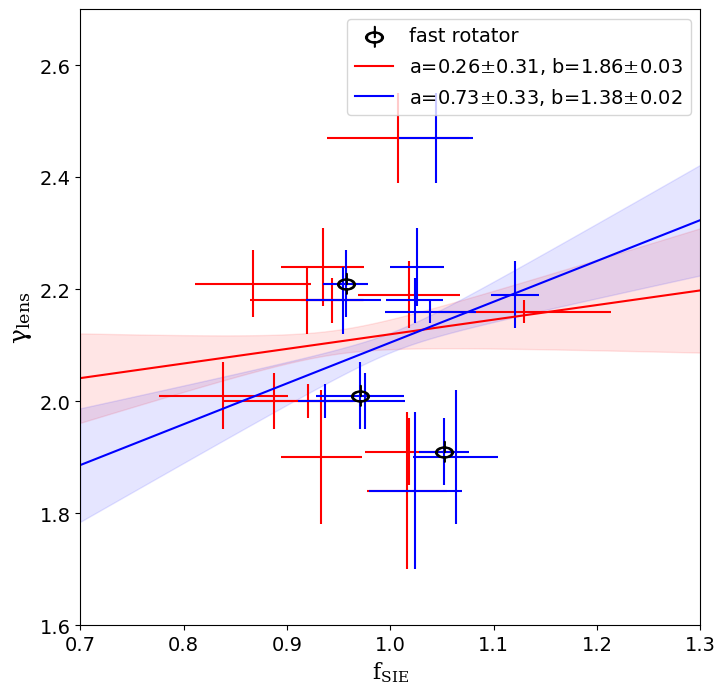

In [166]:


fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(f_sies_sdss[nnnl], gammas[nnnl], 
            xerr=df_sies_sdss[nnnl], yerr=dgammas[nnnl], 
             color='r',
            linestyle='')
axs.errorbar(f_sies_kcwi[nnnl], gammas[nnnl], 
            xerr=df_sies_kcwi[nnnl], yerr=dgammas[nnnl], 
             color='b',
            linestyle='')

# show fast/slow
# plot the symbols for the class distinctions
for i in range(len(obj_names)):
    fs = classes[i]#classifications.loc[i,'lambda_R_class']
    if fs == 'slow':
        #marker = nonregular
        #s = 80
        continue
    elif fs == 'fast':
        marker = rotator
        s = 250
        #plt.scatter(log_Mdyn_half_reff_sdss[i], log_stellar_masses[i], marker=marker, c='k', s=s, zorder=10)
        if i == 3:
            label='fast rotator'
        else:
            label='_nolegend_'
        plt.scatter(f_sies_kcwi[i], gammas[i], marker=marker, c='k', s=s, zorder=10, label=label)

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(f_sies_sdss[nnnl]-1, gammas[nnnl]-2,
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+df_sies_sdss[nnnl]**2),
                    cov='unscaled')
m = p[0]
b = p[1]+2-m
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(0.7, 1.3, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*(x - 1) + bc + 2
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)


# fit a line
p, cov = np.polyfit(f_sies_kcwi[nnnl]-1, gammas[nnnl]-2, 
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+df_sies_kcwi[nnnl]**2),
                    cov='unscaled')
m = p[0]
b = p[1]+2-m
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(0.7, 1.3, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*(x-1)+bc+2
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)



axs.set_xlim(0.7, 1.3)
axs.set_ylim(1.6, 2.7)
axs.set_xlabel(r'$\mathrm{f_{SIE}}$', fontsize=label_fontsize)#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_ylabel(r'$\mathrm{\gamma_{lens}}$', fontsize=18)
axs.legend(loc='upper right')

plt.savefig(f'{kinematics_dir}slacs_x_analysis/gamma_vs_f_sie.pdf', bbox_inches='tight')

# gamma to sigma_1/2

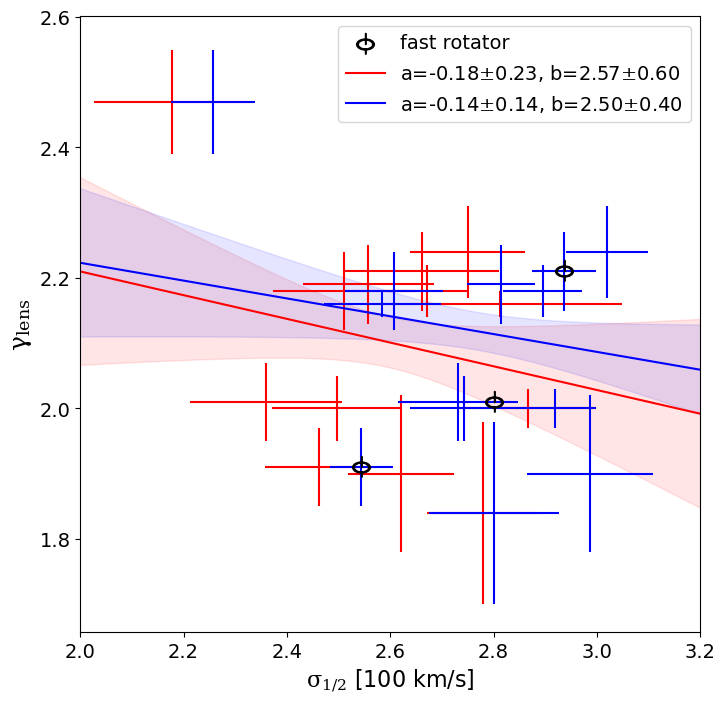

In [165]:
fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(VD_half_reff_sdss[nnnl]/100, gammas[nnnl], # units of 100 km/s
            xerr=dVD_half_reff_sdss[nnnl]/100, yerr=dgammas[nnnl], 
             color='r',
            linestyle='')
axs.errorbar(VD_half_reff_kcwi[nnnl]/100, gammas[nnnl], 
            xerr=dVD_half_reff_kcwi[nnnl]/100, yerr=dgammas[nnnl], 
             color='b',
            linestyle='')
# show fast/slow
# plot the symbols for the class distinctions
for i in range(len(obj_names)):
    fs = classes[i]
    if fs == 'slow':
        #marker = nonregular
        #s = 80
        continue
    elif fs == 'fast':
        marker = rotator
        s = 250
        #plt.scatter(log_Mdyn_half_reff_sdss[i], log_stellar_masses[i], marker=marker, c='k', s=s, zorder=10)
        if i == 3:
            label='fast rotator'
        else:
            label='_nolegend_'
        plt.scatter(VD_half_reff_kcwi[nnnl][i]/100, gammas[i], marker=marker, c='k', s=s, zorder=10, label=label)

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(VD_half_reff_sdss[nnnl]/100, gammas[nnnl]-2, # units of 100 km/s
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+(dVD_half_reff_sdss[nnnl]/100)**2),
                    cov='unscaled'
                   )
m = p[0]
b = p[1]+2
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(1.50, 3.50, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = (ac*(x)+bc)  + 2
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)


# fit a line
p, cov = np.polyfit(VD_half_reff_kcwi[nnnl]/100, gammas[nnnl]-2, # units of 100 km/s
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+(dVD_half_reff_kcwi[nnnl]/100)**2),
                    cov='unscaled'
                   )
m = p[0]
b = p[1]+2
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(1.50, 3.50, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = (ac*x+bc) + 2
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)




axs.set_xlim(2.0, 3.2)
axs.set_xlabel(r'$\mathrm{\sigma_{1/2}}$ [100 km/s]', fontsize=16)#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_ylabel(r'$\mathrm{\gamma_{lens}}$', fontsize=18)
axs.legend()

plt.savefig(f'{kinematics_dir}slacs_x_analysis/gamma_vs_VD_half_reff.pdf', bbox_inches='tight')

# Sigma_tot = M_reff/2 / reff^2
# Do it with density units of 10^11 Msol / kpc^2

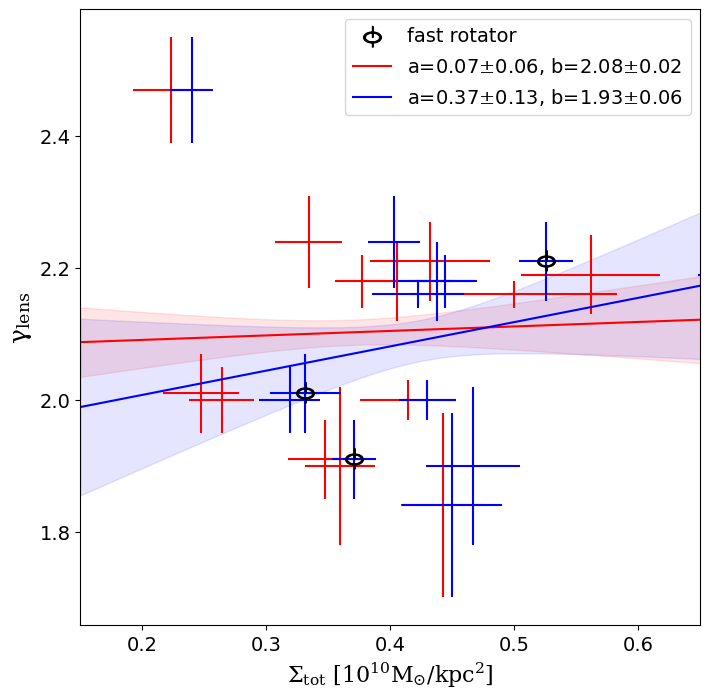

In [168]:
fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(Sigma_tots_sdss[nnnl]/10**10, gammas[nnnl], 
            xerr=dSigma_tots_sdss[nnnl]/10**10, yerr=dgammas[nnnl], 
             color='r',
            linestyle='')
axs.errorbar(Sigma_tots_kcwi[nnnl]/10**10, gammas[nnnl], 
            xerr=dSigma_tots_kcwi[nnnl]/10**10, yerr=dgammas[nnnl], 
             color='b',
            linestyle='')
# show fast/slow
# plot the symbols for the class distinctions
for i in range(len(obj_names)):
    fs = classes[i]
    if fs == 'slow':
        #marker = nonregular
        #s = 80
        continue
    elif fs == 'fast':
        marker = rotator
        s = 250
        #plt.scatter(log_Mdyn_half_reff_sdss[i], log_stellar_masses[i], marker=marker, c='k', s=s, zorder=10)
        if i == 3:
            label='fast rotator'
        else:
            label='_nolegend_'
        plt.scatter(Sigma_tots_kcwi[i]/10**10, gammas[i], marker=marker, c='k', s=s, zorder=10, label=label)
# fit a line to sdss data
# fit a line
p, cov = np.polyfit(Sigma_tots_sdss[nnnl]/10**10, gammas[nnnl]-2,
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+(dSigma_tots_sdss[nnnl]/10**10)**2),
                    cov='unscaled')
m = p[0]
b = p[1]+2
err = np.sqrt(np.diag(cov))/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(0.15, 0.65, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc+2
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)

# fit a line
p, cov = np.polyfit(Sigma_tots_kcwi[nnnl]/10**10, gammas[nnnl]-2, 
                    deg=1,
                    w=1/(dgammas[nnnl]**2+(dSigma_tots_kcwi[nnnl]/10**10)**2),
                    cov=True)
m = p[0]
b = p[1]+2
err = np.sqrt(np.diag(cov))/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(0.15, 0.65, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc+2
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)



axs.set_xlim(0.15, 0.65)
axs.set_xlabel(r'$\mathrm{\Sigma_{tot}}$ $\mathrm{[10^{10}M_{\odot}/kpc^2]}}$', fontsize=label_fontsize)#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_ylabel(r'$\mathrm{\gamma_{lens}}$', fontsize=18)
axs.legend()

plt.savefig(f'{kinematics_dir}slacs_x_analysis/gamma_vs_surface_mass_density.pdf')

# Any redshift evolution?

In [77]:
lambda_Rs

array([0.06259693, 0.14855528, 0.09212595, 0.19529851, 0.05891375,
       0.10901089, 0.08520041, 0.0705594 , 0.0735756 , 0.04483537,
       0.21052038, 0.07630245, 0.09573152, 0.05891509])

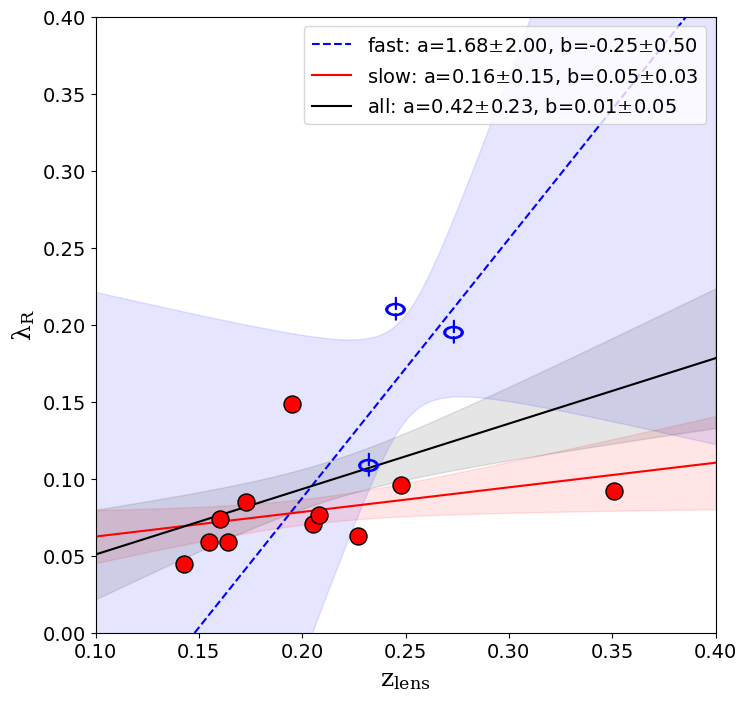

In [171]:
fig, axs = plt.subplots(figsize=(8,8))

# plot the symbols for the class distinctions
for i in range(len(obj_names)):
    fs = classes[i]#paper_table.loc[i,'lambda_R_class']
    if fs == 'slow':
        marker = nonregular
        s = 150
        c='r'
        edgecolor='k'
    elif fs == 'fast':
        marker = rotator
        s = 300
        c='b',
        edgecolor='b'
    #plt.scatter(f_s
    plt.scatter(zlens[i], lambda_Rs[i], marker=marker, c=c, s=s, edgecolor=edgecolor, zorder=10)
    #plt.scatter(VD_half_reff[i]/100, gammas[i], marker=marker, c='k', s=s, zorder=10)

    
##################################
# fast
# fit a line
p, cov = np.polyfit(zlens[fast], lambda_Rs[fast], 
                    deg=1,
                   cov=True)

m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(zlens))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 0.4, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'fast: a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', linestyle='--', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)



################################################
# slow
# fit a line
p, cov = np.polyfit(zlens[slow], lambda_Rs[slow], 
                    deg=1,
                   cov=True)

m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(zlens))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 0.4, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'slow: a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)


################################################
# all
# fit a line
p, cov = np.polyfit(zlens, lambda_Rs, 
                    deg=1,
                   cov=True)

m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(zlens))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 0.4, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'all: a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='k', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)


axs.set_xlim(0.1,0.4)
axs.set_ylim(0, 0.4)
axs.set_ylabel(r'$\mathrm{\lambda_{R}}$', fontsize=18)#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_xlabel(r'$\mathrm{z_{lens}}$', fontsize=18)
axs.legend(loc='upper right')

plt.savefig(f'{kinematics_dir}slacs_x_analysis/lambda_R_vs_redshift_with_lambdar_classes.pdf', bbox_inches='tight')

# Save the paper details

In [84]:
# new details table for paper

paper_table = pd.DataFrame({'obj_name':obj_names,
                           'zlens':zlens,
                           'VD_reff':np.around(VD_ap_int_rms, 0).astype(int),
                           'dVD_reff':np.around(dVD_ap_int_rms, 0).astype(int),
                           'VD_sdss':np.around(VD_slacs_asb, 0).astype(int),
                           'dVD_sdss':np.around(dVD_slacs_asb, 0).astype(int),
                            'reff':np.around(reffs, 2),
                           'ellipticity':np.around(ellipticities, 2),
                           'V_sigma':np.around(V_sigmas, 3), 
                            'lambda_R':np.around(lambda_Rs, 3), 
                            'lambda_R_class':classes})

In [86]:
paper_table

,obj_name,zlens,VD_reff,dVD_reff,VD_sdss,dVD_sdss,reff,ellipticity,V_sigma,lambda_R,lambda_R_class
0,SDSSJ0029-0055,0.227,219,10,216,15,2.30,0.16,0.080,0.063,slow
1,SDSSJ0037-0942,0.195,277,9,265,8,2.30,0.27,0.162,0.149,slow
2,SDSSJ0330-0020,0.351,251,13,273,23,1.26,0.23,0.109,0.092,slow
3,SDSSJ1112+0826,0.273,283,7,260,15,1.55,0.23,0.220,0.195,fast
4,SDSSJ1204+0358,0.164,272,9,251,12,1.63,0.03,0.070,0.059,slow
5,SDSSJ1250+0523,0.232,240,8,242,10,1.86,0.03,0.125,0.109,fast
6,SDSSJ1306+0600,0.173,250,12,248,14,2.08,0.09,0.100,0.085,slow
7,SDSSJ1402+6321,0.205,293,9,274,11,2.65,0.23,0.084,0.071,slow
8,SDSSJ1531-0105,0.160,290,13,261,10,2.73,0.32,0.085,0.074,slow
9,SDSSJ1538+5817,0.143,247,9,177,9,1.45,0.18,0.050,0.045,slow


In [90]:
paper_table.to_csv(f'{kinematics_dir}paper_table_022224.csv', index=False)

In [91]:
paper_table.to_latex(buf=f'{kinematics_dir}paper_table_022224.tex',index=False)

# Oblate vs prolate

Text(0, 0.5, '$\\mathrm{\\Delta}$PA')

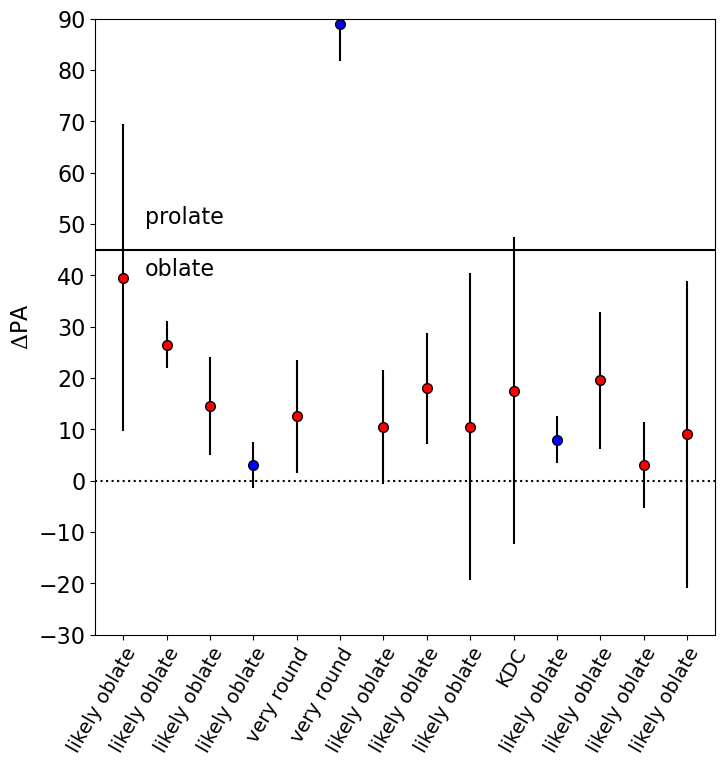

In [173]:
oblate_prolate = np.empty(14, dtype='U15')
markers = ['o','^','s']

fig, ax = plt.subplots(figsize=(8,8))
for i, obj_name in enumerate(obj_names): 

    file = f'{kinematics_dir}{obj_name}/{obj_name}_axis_info_xshooter_2024_02_15.txt'
    kin_axis = np.genfromtxt(file, delimiter=',') 
    # PA_kin, dPA_kin, PA_phot, delta_PA, ellipticity
    
    # take delta_PA (diff between kinematic and photometric axes)
    delta_PA = np.abs(kin_axis[3])
    if delta_PA > 90:
        delta_PA = np.abs(180-delta_PA)
    dPA = kin_axis[1]
    #slacs_delta_PA = np.abs(classifications.loc[i, 'SLACS delta_PA'])
    ellipticity = paper_table.loc[i, 'ellipticity']
    classification = classes[i]# paper_table.loc[i, 'lambda_R_class']
    if classification == 'fast':
        color='b' # blue means fast/regular
    else:
        color='r' # red
    if i == 9:
        label='KDC'
        oblate_prolate[i]=label
    elif ellipticity < 0.05:
        label='very round'
        oblate_prolate[i]=label
    elif (delta_PA < 45) & (dPA < 45):
        label='likely oblate'
        oblate_prolate[i]=label
    elif (delta_PA > 45) & (dPA < 45):
        label='likely prolate'
        oblate_prolate[i]=label
    else:
        label='uncertain'
        oblate_prolate[i]=label
            
    ax.errorbar(i, delta_PA, yerr=dPA, marker=markers[0], color=color, markersize=7, markeredgecolor='k', ecolor='k', ls='')
    
plt.rcParams.update({'font.size': 16})


ax.set_ylim(-30, 90)
ax.axhline(45, color='k')
ax.axhline(0, color='k', linestyle=':')
ax.annotate('prolate',(0.5,50))
ax.annotate('oblate',(0.5,40))
ax.set_xticks(range(14), labels=oblate_prolate, rotation=60, ha='right', rotation_mode='anchor', fontsize=14)
ax.set_yticks(np.linspace(-30, 90, 13))
delta_pa_symbol = r'$\mathrm{\Delta}$PA'
ax.set_ylabel(delta_pa_symbol, rotation=90)
#plt.savefig(f'{kinematics_dir}oblate_prolate_marg_gnog_allsn.pdf', bbox_inches='tight')

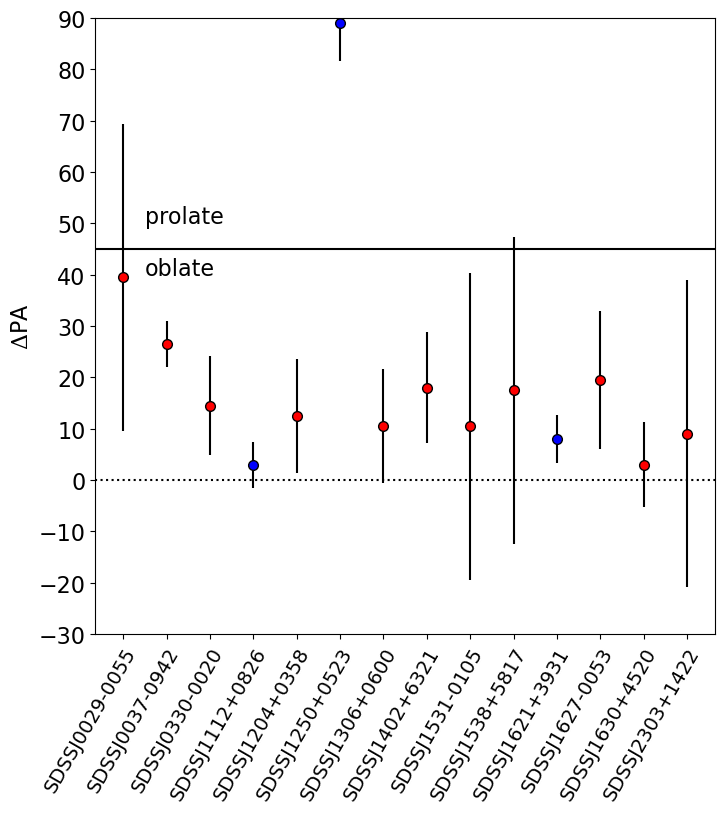

In [174]:
oblate_prolate = np.empty(14, dtype='U15')
markers = ['o','^','s']

fig, ax = plt.subplots(figsize=(8,8))
for i, obj_name in enumerate(obj_names): 

    file = f'{kinematics_dir}{obj_name}/{obj_name}_axis_info_xshooter_2024_02_15.txt'
    kin_axis = np.genfromtxt(file, delimiter=',') 
    # PA_kin, dPA_kin, PA_phot, delta_PA, ellipticity
    
    # take delta_PA (diff between kinematic and photometric axes)
    delta_PA = np.abs(kin_axis[3])
    if delta_PA > 90:
        delta_PA = np.abs(180-delta_PA)
    dPA = kin_axis[1]
    #slacs_delta_PA = np.abs(classifications.loc[i, 'SLACS delta_PA'])
    ellipticity = paper_table.loc[i, 'ellipticity']
    classification = classes[i]# paper_table.loc[i, 'lambda_R_class']
    if classification == 'fast':
        color='b' # blue means fast/regular
    else:
        color='r' # red
    if i == 9:
        label='KDC'
        oblate_prolate[i]=label
    elif ellipticity < 0.05:
        label='very round'
        oblate_prolate[i]=label
    elif (delta_PA < 45) & (dPA < 45):
        label='likely oblate'
        oblate_prolate[i]=label
    elif (delta_PA > 45) & (dPA < 45):
        label='likely prolate'
        oblate_prolate[i]=label
    else:
        label='uncertain'
        oblate_prolate[i]=label
            
    ax.errorbar(i, delta_PA, yerr=dPA, marker=markers[0], color=color, markersize=7, markeredgecolor='k', ecolor='k', ls='')
    
plt.rcParams.update({'font.size': 16})

ax.set_ylim(-30, 90)
ax.axhline(45, color='k')
ax.axhline(0, color='k', linestyle=':')
ax.annotate('prolate',(0.5,50))
ax.annotate('oblate',(0.5,40))
ax.set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor', fontsize=14)
ax.set_yticks(np.linspace(-30, 90, 13))
delta_pa_symbol = r'$\mathrm{\Delta}$PA'
ax.set_ylabel(delta_pa_symbol, rotation=90)

#plt.savefig(f'{kinematics_dir}oblate_prolate.pdf', bbox_inches='tight')

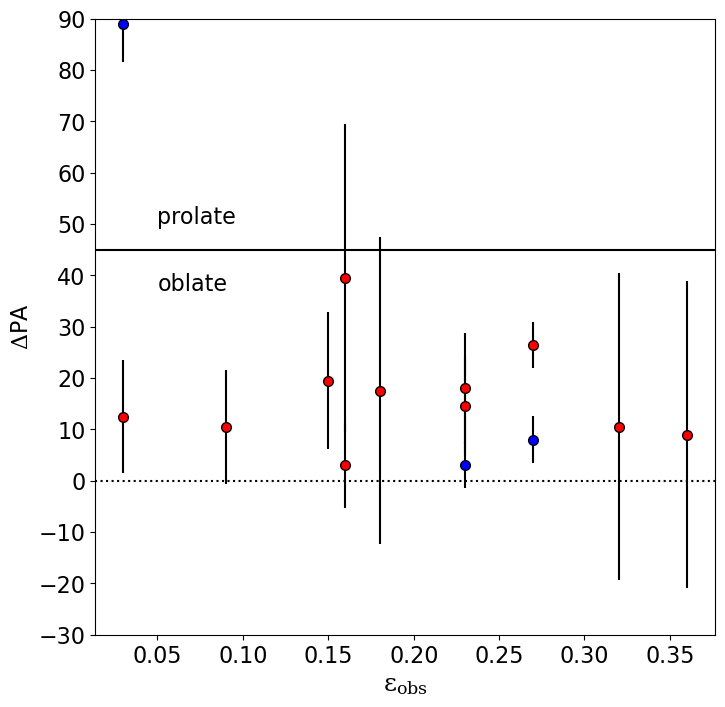

In [176]:
oblate_prolate = np.empty(14, dtype='U15')
markers = ['o','^','s']

fig, ax = plt.subplots(figsize=(8,8))
for i, obj_name in enumerate(obj_names): 

    file = f'{kinematics_dir}{obj_name}/{obj_name}_axis_info_xshooter_2024_02_15.txt'
    kin_axis = np.genfromtxt(file, delimiter=',') 
    # PA_kin, dPA_kin, PA_phot, delta_PA, ellipticity
    
    # take delta_PA (diff between kinematic and photometric axes)
    delta_PA = np.abs(kin_axis[3])
    if delta_PA > 90:
        delta_PA = np.abs(180-delta_PA)
    dPA = kin_axis[1]
    #slacs_delta_PA = np.abs(classifications.loc[i, 'SLACS delta_PA'])
    ellipticity = paper_table.loc[i, 'ellipticity']
    classification = classes[i]# paper_table.loc[i, 'lambda_R_class']
    if classification == 'fast':
        color='b' # blue means fast/regular
    else:
        color='r' # red
    if i == 9:
        label='KDC'
        oblate_prolate[i]=label
    elif ellipticity < 0.05:
        label='very round'
        oblate_prolate[i]=label
    elif (delta_PA < 45) & (dPA < 45):
        label='likely oblate'
        oblate_prolate[i]=label
    elif (delta_PA > 45) & (dPA < 45):
        label='likely prolate'
        oblate_prolate[i]=label
    else:
        label='uncertain'
        oblate_prolate[i]=label
            
    ax.errorbar(ellipticity, delta_PA, yerr=dPA, marker=markers[0], color=color, markersize=7, markeredgecolor='k', ecolor='k', ls='')
    
plt.rcParams.update({'font.size': 16})

ax.set_ylim(-30, 90)
ax.axhline(45, color='k')
ax.axhline(0, color='k', linestyle=':')
ax.annotate('prolate',(0.05,50))
ax.annotate('oblate',(0.05,37))
#ax.set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor', fontsize=14)
ax.set_yticks(np.linspace(-30, 90, 13))
delta_pa_symbol = r'$\mathrm{\Delta}$PA'
ax.set_ylabel(delta_pa_symbol, rotation=90)
ax.set_xlabel(r'$\mathrm{\epsilon_{obs}}$', fontsize=18)

plt.savefig(f'{kinematics_dir}oblate_prolate.pdf', bbox_inches='tight')

In [99]:
oblate_prolate

array(['likely oblate', 'likely oblate', 'likely oblate', 'likely oblate',
       'very round', 'very round', 'likely oblate', 'likely oblate',
       'likely oblate', 'KDC', 'likely oblate', 'likely oblate',
       'likely oblate', 'likely oblate'], dtype='<U15')